In [1]:
import gc
import torch
import pandas as pd
import numpy as np
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt

import constants
from model.center_net import MyUNet,criterion
from car_dataset import CarDataset

In [2]:
constants.PATH

'../basement-scientists/pku-auto-drive/'

In [3]:
train = pd.read_csv(constants.PATH + '/train.csv')
test = pd.read_csv(constants.PATH + '/sample_submission.csv')
train_images_dir = constants.PATH + 'train_images/{}.jpg'
test_images_dir = constants.PATH + 'test_images/{}.jpg'

df_train, df_dev = train_test_split(train, test_size=0.01, random_state=42)
df_test = test

In [4]:
# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir, training=True)
dev_dataset = CarDataset(df_dev, train_images_dir, training=False)
test_dataset = CarDataset(df_test, test_images_dir, training=False)

BATCH_SIZE = 1
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [5]:
device = torch.device("cuda")
model = MyUNet(8).to(device)
model.load_state_dict(torch.load("ckpt/model.pth"))

Loaded pretrained weights for efficientnet-b0
The number of classes is 8


<All keys matched successfully>

In [6]:
model.eval()

MyUNet(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_pr

In [7]:
# img, mask, regr = dev_dataset[1]

# plt.figure(figsize=(16,16))
# plt.title('Input image')
# plt.imshow(np.rollaxis(img, 0, 3))
# plt.show()

# plt.figure(figsize=(16,16))
# plt.title('Ground truth mask')
# plt.imshow(mask)
# plt.show()

# output = model(torch.tensor(img[None]).to(device))
# logits = output[0,0].data.cpu().numpy()
# print(logits.shape)
# print(np.max(logits))

# plt.figure(figsize=(16,16))
# plt.title('Model predictions')
# plt.imshow(logits)
# plt.show()

# plt.figure(figsize=(16,16))
# plt.title('Model predictions thresholded')
# plt.imshow(logits > 0)
# plt.show()

# logits

In [8]:
import gc
print(device)
torch.cuda.empty_cache()
gc.collect()

cuda


7

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])
output: (1, 8, 60, 192)


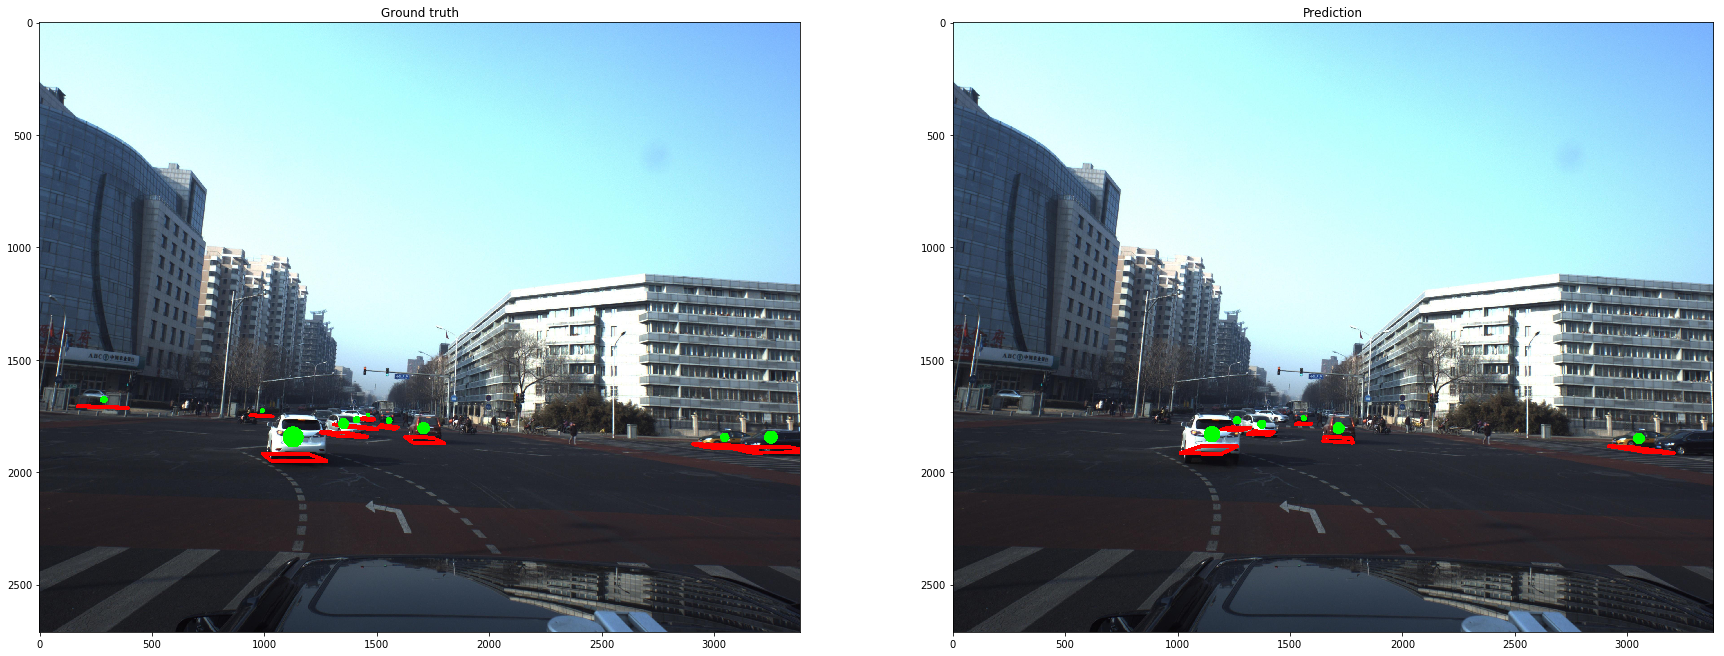

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])
output: (1, 8, 60, 192)


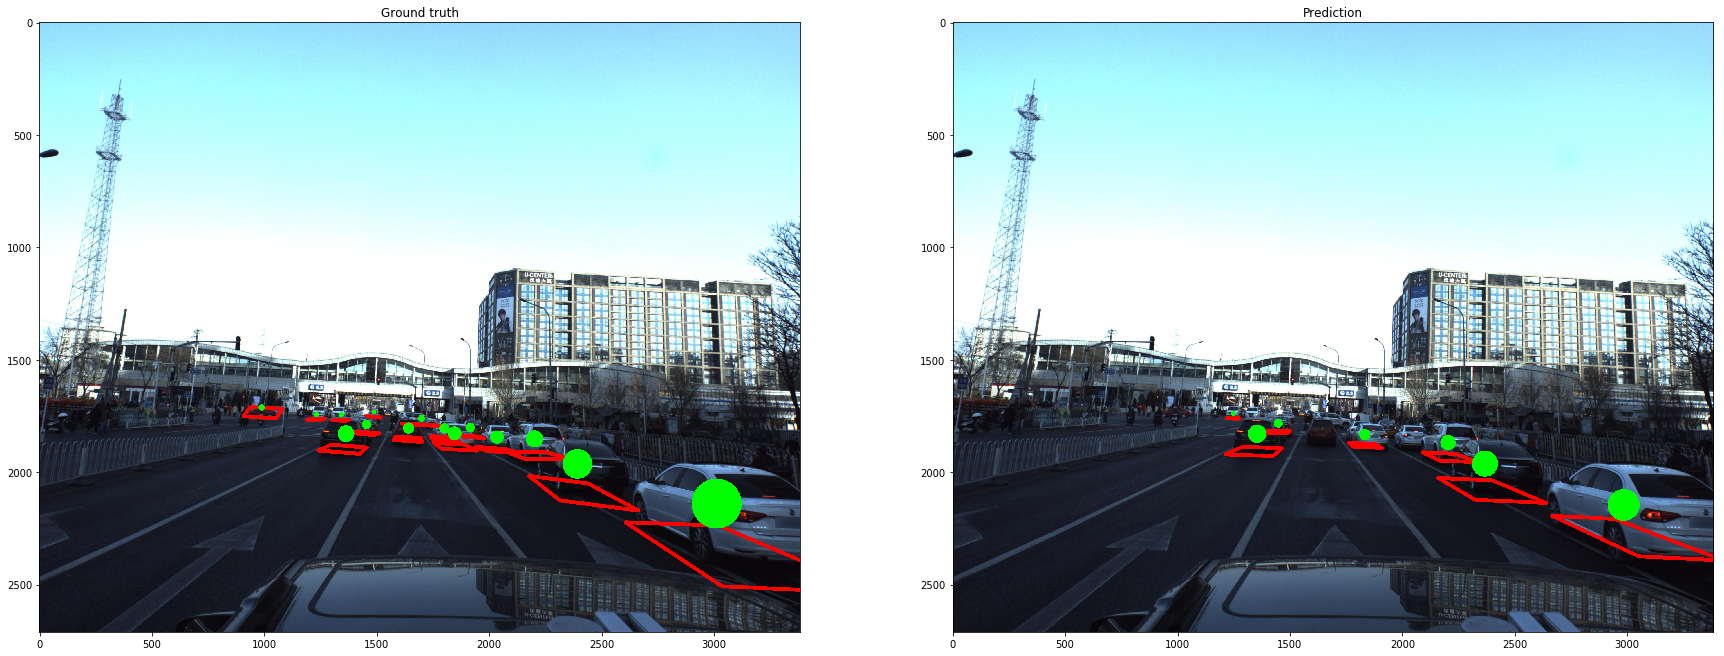

In [9]:
from util import *

gc.collect()

for idx in range(2):
    img, mask, regr = dev_dataset[idx]
    
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()
    print("output:", output.shape)
    coords_pred = extract_coords(output[0])
    coords_true = extract_coords(np.concatenate([mask[None], regr], 0))
    
    img = imread(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
    
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred))
    
    plt.show()

In [10]:
predictions = []

model.eval()

for img, _, _ in tqdm(test_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out)
        s = coords2str(coords)
        predictions.append(s)

  0%|                                                                                         | 0/2021 [00:00<?, ?it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  0%|                                                                               | 1/2021 [00:05<3:03:49,  5.46s/it]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  0%|                                                                               | 2/2021 [00:05<2:10:46,  3.89s/it]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  0%|                                                                               | 3/2021 [00:05<1:33:36,  2.78s/it]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  0%|▏                                                                              | 4/2021 [00:06<1:07:52,  2.02s/it]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  0%|▏                                                                                | 5/2021 [00:06<49:36,  1.48s/it]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  0%|▏                                                                                | 6/2021 [00:06<36:48,  1.10s/it]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  0%|▎                                                                                | 7/2021 [00:06<28:04,  1.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  0%|▎                                                                                | 8/2021 [00:06<21:45,  1.54it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  0%|▎                                                                                | 9/2021 [00:07<17:37,  1.90it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  0%|▍                                                                               | 10/2021 [00:07<14:19,  2.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▍                                                                               | 11/2021 [00:07<12:08,  2.76it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▍                                                                               | 12/2021 [00:07<10:55,  3.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▌                                                                               | 13/2021 [00:08<10:02,  3.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▌                                                                               | 14/2021 [00:08<09:05,  3.68it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▌                                                                               | 15/2021 [00:08<08:39,  3.86it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▋                                                                               | 16/2021 [00:08<08:35,  3.89it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▋                                                                               | 17/2021 [00:09<08:12,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▋                                                                               | 18/2021 [00:09<08:09,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▊                                                                               | 19/2021 [00:09<07:46,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▊                                                                               | 20/2021 [00:09<07:52,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▊                                                                               | 21/2021 [00:09<07:33,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▊                                                                               | 22/2021 [00:10<07:25,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▉                                                                               | 23/2021 [00:10<07:49,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▉                                                                               | 24/2021 [00:10<07:32,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|▉                                                                               | 25/2021 [00:10<08:00,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|█                                                                               | 26/2021 [00:11<08:04,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|█                                                                               | 27/2021 [00:11<08:06,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|█                                                                               | 28/2021 [00:11<07:49,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|█▏                                                                              | 29/2021 [00:11<07:53,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  1%|█▏                                                                              | 30/2021 [00:12<08:12,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▏                                                                              | 31/2021 [00:12<07:48,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▎                                                                              | 32/2021 [00:12<07:41,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▎                                                                              | 33/2021 [00:12<07:53,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▎                                                                              | 34/2021 [00:13<07:47,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▍                                                                              | 35/2021 [00:13<07:39,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▍                                                                              | 36/2021 [00:13<08:01,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▍                                                                              | 37/2021 [00:13<07:59,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▌                                                                              | 38/2021 [00:13<07:43,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▌                                                                              | 39/2021 [00:14<07:37,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▌                                                                              | 40/2021 [00:14<07:51,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▌                                                                              | 41/2021 [00:14<07:59,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▋                                                                              | 42/2021 [00:14<07:50,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▋                                                                              | 43/2021 [00:15<08:01,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▋                                                                              | 44/2021 [00:15<07:57,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▊                                                                              | 45/2021 [00:15<07:44,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▊                                                                              | 46/2021 [00:15<07:58,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▊                                                                              | 47/2021 [00:16<08:10,  4.02it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▉                                                                              | 48/2021 [00:16<08:04,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▉                                                                              | 49/2021 [00:16<08:02,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  2%|█▉                                                                              | 50/2021 [00:16<07:58,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██                                                                              | 51/2021 [00:17<07:49,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██                                                                              | 52/2021 [00:17<07:55,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██                                                                              | 53/2021 [00:17<07:40,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▏                                                                             | 54/2021 [00:17<07:28,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▏                                                                             | 55/2021 [00:18<07:45,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▏                                                                             | 56/2021 [00:18<07:28,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▎                                                                             | 57/2021 [00:18<07:32,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▎                                                                             | 58/2021 [00:18<07:39,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▎                                                                             | 59/2021 [00:18<07:29,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▍                                                                             | 60/2021 [00:19<07:31,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▍                                                                             | 61/2021 [00:19<07:31,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▍                                                                             | 62/2021 [00:19<07:35,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▍                                                                             | 63/2021 [00:19<07:21,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▌                                                                             | 64/2021 [00:20<07:12,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▌                                                                             | 65/2021 [00:20<07:40,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▌                                                                             | 66/2021 [00:20<07:44,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▋                                                                             | 67/2021 [00:20<07:39,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▋                                                                             | 68/2021 [00:21<07:26,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▋                                                                             | 69/2021 [00:21<07:25,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  3%|██▊                                                                             | 70/2021 [00:21<07:22,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|██▊                                                                             | 71/2021 [00:21<07:34,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|██▊                                                                             | 72/2021 [00:21<07:35,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|██▉                                                                             | 73/2021 [00:22<07:26,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|██▉                                                                             | 74/2021 [00:22<07:16,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|██▉                                                                             | 75/2021 [00:22<07:18,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███                                                                             | 76/2021 [00:22<07:17,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███                                                                             | 77/2021 [00:23<07:02,  4.60it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███                                                                             | 78/2021 [00:23<07:19,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███▏                                                                            | 79/2021 [00:23<07:34,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███▏                                                                            | 80/2021 [00:23<07:19,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███▏                                                                            | 81/2021 [00:23<07:09,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███▏                                                                            | 82/2021 [00:24<07:21,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███▎                                                                            | 83/2021 [00:24<07:09,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███▎                                                                            | 84/2021 [00:24<07:07,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███▎                                                                            | 85/2021 [00:24<07:23,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███▍                                                                            | 86/2021 [00:25<07:12,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███▍                                                                            | 87/2021 [00:25<07:05,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███▍                                                                            | 88/2021 [00:25<07:01,  4.58it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███▌                                                                            | 89/2021 [00:25<07:04,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  4%|███▌                                                                            | 90/2021 [00:25<07:08,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|███▌                                                                            | 91/2021 [00:26<06:59,  4.60it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|███▋                                                                            | 92/2021 [00:26<06:57,  4.62it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|███▋                                                                            | 93/2021 [00:26<07:19,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|███▋                                                                            | 94/2021 [00:26<07:12,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|███▊                                                                            | 95/2021 [00:27<07:17,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|███▊                                                                            | 96/2021 [00:27<07:15,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|███▊                                                                            | 97/2021 [00:27<07:22,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|███▉                                                                            | 98/2021 [00:27<07:09,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|███▉                                                                            | 99/2021 [00:27<07:20,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|███▉                                                                           | 100/2021 [00:28<07:19,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|███▉                                                                           | 101/2021 [00:28<07:07,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|███▉                                                                           | 102/2021 [00:28<06:59,  4.57it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|████                                                                           | 103/2021 [00:28<07:19,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|████                                                                           | 104/2021 [00:29<07:24,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|████                                                                           | 105/2021 [00:29<07:22,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|████▏                                                                          | 106/2021 [00:29<07:15,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|████▏                                                                          | 107/2021 [00:29<07:25,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|████▏                                                                          | 108/2021 [00:30<07:13,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|████▎                                                                          | 109/2021 [00:30<07:05,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|████▎                                                                          | 110/2021 [00:30<06:59,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  5%|████▎                                                                          | 111/2021 [00:30<07:02,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▍                                                                          | 112/2021 [00:30<07:02,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▍                                                                          | 113/2021 [00:31<07:05,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▍                                                                          | 114/2021 [00:31<07:01,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▍                                                                          | 115/2021 [00:31<07:12,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▌                                                                          | 116/2021 [00:31<07:22,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▌                                                                          | 117/2021 [00:32<07:23,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▌                                                                          | 118/2021 [00:32<07:31,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▋                                                                          | 119/2021 [00:32<07:16,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▋                                                                          | 120/2021 [00:32<07:16,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▋                                                                          | 121/2021 [00:32<07:07,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▊                                                                          | 122/2021 [00:33<07:20,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▊                                                                          | 123/2021 [00:33<07:22,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▊                                                                          | 124/2021 [00:33<07:11,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▉                                                                          | 125/2021 [00:33<07:06,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▉                                                                          | 126/2021 [00:34<07:06,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|████▉                                                                          | 127/2021 [00:34<06:59,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|█████                                                                          | 128/2021 [00:34<07:15,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|█████                                                                          | 129/2021 [00:34<07:12,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|█████                                                                          | 130/2021 [00:35<07:26,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  6%|█████                                                                          | 131/2021 [00:35<07:24,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▏                                                                         | 132/2021 [00:35<07:11,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▏                                                                         | 133/2021 [00:35<07:06,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▏                                                                         | 134/2021 [00:35<07:20,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▎                                                                         | 135/2021 [00:36<07:03,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▎                                                                         | 136/2021 [00:36<06:56,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▎                                                                         | 137/2021 [00:36<07:05,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▍                                                                         | 138/2021 [00:36<07:21,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▍                                                                         | 139/2021 [00:37<07:18,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▍                                                                         | 140/2021 [00:37<07:18,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▌                                                                         | 141/2021 [00:37<07:02,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▌                                                                         | 142/2021 [00:37<06:53,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▌                                                                         | 143/2021 [00:38<07:23,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▋                                                                         | 144/2021 [00:38<07:17,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▋                                                                         | 145/2021 [00:38<07:10,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▋                                                                         | 146/2021 [00:38<07:23,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▋                                                                         | 147/2021 [00:38<07:20,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▊                                                                         | 148/2021 [00:39<07:21,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▊                                                                         | 149/2021 [00:39<07:27,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▊                                                                         | 150/2021 [00:39<07:39,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  7%|█████▉                                                                         | 151/2021 [00:39<07:36,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|█████▉                                                                         | 152/2021 [00:40<07:43,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|█████▉                                                                         | 153/2021 [00:40<07:27,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████                                                                         | 154/2021 [00:40<07:27,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████                                                                         | 155/2021 [00:40<07:31,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████                                                                         | 156/2021 [00:41<07:24,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▏                                                                        | 157/2021 [00:41<07:28,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▏                                                                        | 158/2021 [00:41<07:30,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▏                                                                        | 159/2021 [00:41<07:30,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▎                                                                        | 160/2021 [00:42<07:17,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▎                                                                        | 161/2021 [00:42<07:25,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▎                                                                        | 162/2021 [00:42<07:13,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▎                                                                        | 163/2021 [00:42<07:36,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▍                                                                        | 164/2021 [00:43<07:39,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▍                                                                        | 165/2021 [00:43<07:24,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▍                                                                        | 166/2021 [00:43<07:28,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▌                                                                        | 167/2021 [00:43<07:17,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▌                                                                        | 168/2021 [00:44<07:14,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▌                                                                        | 169/2021 [00:44<07:06,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▋                                                                        | 170/2021 [00:44<07:19,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  8%|██████▋                                                                        | 171/2021 [00:44<07:43,  3.99it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|██████▋                                                                        | 172/2021 [00:44<07:29,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|██████▊                                                                        | 173/2021 [00:45<07:25,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|██████▊                                                                        | 174/2021 [00:45<07:19,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|██████▊                                                                        | 175/2021 [00:45<07:06,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|██████▉                                                                        | 176/2021 [00:45<07:18,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|██████▉                                                                        | 177/2021 [00:46<07:17,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|██████▉                                                                        | 178/2021 [00:46<07:03,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|██████▉                                                                        | 179/2021 [00:46<07:14,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|███████                                                                        | 180/2021 [00:46<06:56,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|███████                                                                        | 181/2021 [00:47<06:48,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|███████                                                                        | 182/2021 [00:47<06:42,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|███████▏                                                                       | 183/2021 [00:47<06:42,  4.57it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|███████▏                                                                       | 184/2021 [00:47<06:51,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|███████▏                                                                       | 185/2021 [00:47<06:40,  4.58it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|███████▎                                                                       | 186/2021 [00:48<06:36,  4.63it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|███████▎                                                                       | 187/2021 [00:48<06:51,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|███████▎                                                                       | 188/2021 [00:48<06:45,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|███████▍                                                                       | 189/2021 [00:48<06:46,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|███████▍                                                                       | 190/2021 [00:49<06:41,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


  9%|███████▍                                                                       | 191/2021 [00:49<06:39,  4.58it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▌                                                                       | 192/2021 [00:49<06:40,  4.57it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▌                                                                       | 193/2021 [00:49<06:47,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▌                                                                       | 194/2021 [00:49<06:38,  4.58it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▌                                                                       | 195/2021 [00:50<06:34,  4.62it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▋                                                                       | 196/2021 [00:50<06:53,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▋                                                                       | 197/2021 [00:50<06:40,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▋                                                                       | 198/2021 [00:50<06:51,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▊                                                                       | 199/2021 [00:50<06:39,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▊                                                                       | 200/2021 [00:51<06:46,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▊                                                                       | 201/2021 [00:51<06:41,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▉                                                                       | 202/2021 [00:51<06:34,  4.62it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▉                                                                       | 203/2021 [00:51<06:37,  4.57it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|███████▉                                                                       | 204/2021 [00:52<06:30,  4.65it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|████████                                                                       | 205/2021 [00:52<06:31,  4.64it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|████████                                                                       | 206/2021 [00:52<06:46,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|████████                                                                       | 207/2021 [00:52<06:59,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|████████▏                                                                      | 208/2021 [00:53<07:02,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|████████▏                                                                      | 209/2021 [00:53<07:01,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|████████▏                                                                      | 210/2021 [00:53<06:58,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|████████▏                                                                      | 211/2021 [00:53<06:48,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 10%|████████▎                                                                      | 212/2021 [00:53<06:41,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▎                                                                      | 213/2021 [00:54<06:34,  4.58it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▎                                                                      | 214/2021 [00:54<06:30,  4.63it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▍                                                                      | 215/2021 [00:54<06:47,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▍                                                                      | 216/2021 [00:54<07:00,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▍                                                                      | 217/2021 [00:55<06:55,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▌                                                                      | 218/2021 [00:55<06:44,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▌                                                                      | 219/2021 [00:55<06:39,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▌                                                                      | 220/2021 [00:55<06:56,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▋                                                                      | 221/2021 [00:55<07:00,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▋                                                                      | 222/2021 [00:56<06:52,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▋                                                                      | 223/2021 [00:56<06:40,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▊                                                                      | 224/2021 [00:56<06:32,  4.58it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▊                                                                      | 225/2021 [00:56<06:45,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▊                                                                      | 226/2021 [00:57<06:39,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▊                                                                      | 227/2021 [00:57<06:36,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▉                                                                      | 228/2021 [00:57<06:33,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▉                                                                      | 229/2021 [00:57<06:58,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|████████▉                                                                      | 230/2021 [00:58<07:05,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|█████████                                                                      | 231/2021 [00:58<06:58,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 11%|█████████                                                                      | 232/2021 [00:58<07:14,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████                                                                      | 233/2021 [00:58<07:06,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▏                                                                     | 234/2021 [00:58<06:56,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▏                                                                     | 235/2021 [00:59<06:45,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▏                                                                     | 236/2021 [00:59<06:37,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▎                                                                     | 237/2021 [00:59<06:52,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▎                                                                     | 238/2021 [00:59<06:55,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▎                                                                     | 239/2021 [01:00<06:40,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▍                                                                     | 240/2021 [01:00<06:53,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▍                                                                     | 241/2021 [01:00<06:39,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▍                                                                     | 242/2021 [01:00<06:49,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▍                                                                     | 243/2021 [01:00<06:34,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▌                                                                     | 244/2021 [01:01<06:42,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▌                                                                     | 245/2021 [01:01<06:31,  4.54it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▌                                                                     | 246/2021 [01:01<06:33,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▋                                                                     | 247/2021 [01:01<06:42,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▋                                                                     | 248/2021 [01:02<06:40,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▋                                                                     | 249/2021 [01:02<06:45,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▊                                                                     | 250/2021 [01:02<06:51,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▊                                                                     | 251/2021 [01:02<06:51,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 12%|█████████▊                                                                     | 252/2021 [01:03<06:48,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|█████████▉                                                                     | 253/2021 [01:03<06:38,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|█████████▉                                                                     | 254/2021 [01:03<06:31,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|█████████▉                                                                     | 255/2021 [01:03<06:26,  4.57it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████                                                                     | 256/2021 [01:03<06:33,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████                                                                     | 257/2021 [01:04<06:24,  4.58it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████                                                                     | 258/2021 [01:04<06:36,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████                                                                     | 259/2021 [01:04<06:25,  4.57it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▏                                                                    | 260/2021 [01:04<06:26,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▏                                                                    | 261/2021 [01:05<06:30,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▏                                                                    | 262/2021 [01:05<06:23,  4.59it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▎                                                                    | 263/2021 [01:05<06:28,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▎                                                                    | 264/2021 [01:05<06:38,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▎                                                                    | 265/2021 [01:05<06:26,  4.54it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▍                                                                    | 266/2021 [01:06<06:41,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▍                                                                    | 267/2021 [01:06<06:33,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▍                                                                    | 268/2021 [01:06<06:24,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▌                                                                    | 269/2021 [01:06<06:30,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▌                                                                    | 270/2021 [01:07<06:38,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▌                                                                    | 271/2021 [01:07<06:43,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 13%|██████████▋                                                                    | 272/2021 [01:07<06:52,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|██████████▋                                                                    | 273/2021 [01:07<06:38,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|██████████▋                                                                    | 274/2021 [01:07<06:45,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|██████████▋                                                                    | 275/2021 [01:08<06:37,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|██████████▊                                                                    | 276/2021 [01:08<06:32,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|██████████▊                                                                    | 277/2021 [01:08<06:42,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|██████████▊                                                                    | 278/2021 [01:08<06:40,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|██████████▉                                                                    | 279/2021 [01:09<06:40,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|██████████▉                                                                    | 280/2021 [01:09<06:32,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|██████████▉                                                                    | 281/2021 [01:09<06:44,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|███████████                                                                    | 282/2021 [01:09<06:51,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|███████████                                                                    | 283/2021 [01:10<06:42,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|███████████                                                                    | 284/2021 [01:10<07:02,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|███████████▏                                                                   | 285/2021 [01:10<07:07,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|███████████▏                                                                   | 286/2021 [01:10<07:25,  3.89it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|███████████▏                                                                   | 287/2021 [01:11<07:17,  3.97it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|███████████▎                                                                   | 288/2021 [01:11<07:20,  3.94it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|███████████▎                                                                   | 289/2021 [01:11<07:09,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|███████████▎                                                                   | 290/2021 [01:11<07:08,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|███████████▍                                                                   | 291/2021 [01:12<06:50,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|███████████▍                                                                   | 292/2021 [01:12<06:38,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 14%|███████████▍                                                                   | 293/2021 [01:12<06:35,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▍                                                                   | 294/2021 [01:12<06:26,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▌                                                                   | 295/2021 [01:12<06:23,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▌                                                                   | 296/2021 [01:13<06:24,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▌                                                                   | 297/2021 [01:13<06:19,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▋                                                                   | 298/2021 [01:13<06:35,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▋                                                                   | 299/2021 [01:13<06:32,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▋                                                                   | 300/2021 [01:14<06:36,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▊                                                                   | 301/2021 [01:14<06:24,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▊                                                                   | 302/2021 [01:14<06:17,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▊                                                                   | 303/2021 [01:14<06:12,  4.61it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▉                                                                   | 304/2021 [01:14<06:21,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▉                                                                   | 305/2021 [01:15<06:21,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|███████████▉                                                                   | 306/2021 [01:15<06:25,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|████████████                                                                   | 307/2021 [01:15<06:28,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|████████████                                                                   | 308/2021 [01:15<06:28,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|████████████                                                                   | 309/2021 [01:16<06:35,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|████████████                                                                   | 310/2021 [01:16<06:23,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|████████████▏                                                                  | 311/2021 [01:16<06:18,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|████████████▏                                                                  | 312/2021 [01:16<06:10,  4.61it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 15%|████████████▏                                                                  | 313/2021 [01:16<06:21,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▎                                                                  | 314/2021 [01:17<06:14,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▎                                                                  | 315/2021 [01:17<06:12,  4.58it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▎                                                                  | 316/2021 [01:17<06:09,  4.61it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▍                                                                  | 317/2021 [01:17<06:28,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▍                                                                  | 318/2021 [01:18<06:29,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▍                                                                  | 319/2021 [01:18<06:39,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▌                                                                  | 320/2021 [01:18<06:37,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▌                                                                  | 321/2021 [01:18<06:26,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▌                                                                  | 322/2021 [01:19<06:33,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▋                                                                  | 323/2021 [01:19<06:20,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▋                                                                  | 324/2021 [01:19<06:11,  4.57it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▋                                                                  | 325/2021 [01:19<06:23,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▋                                                                  | 326/2021 [01:19<06:19,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▊                                                                  | 327/2021 [01:20<06:29,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▊                                                                  | 328/2021 [01:20<06:31,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▊                                                                  | 329/2021 [01:20<06:41,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▉                                                                  | 330/2021 [01:20<06:45,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▉                                                                  | 331/2021 [01:21<06:36,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|████████████▉                                                                  | 332/2021 [01:21<06:25,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 16%|█████████████                                                                  | 333/2021 [01:21<06:23,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████                                                                  | 334/2021 [01:21<06:24,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████                                                                  | 335/2021 [01:21<06:29,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▏                                                                 | 336/2021 [01:22<06:22,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▏                                                                 | 337/2021 [01:22<06:32,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▏                                                                 | 338/2021 [01:22<06:32,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▎                                                                 | 339/2021 [01:22<06:30,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▎                                                                 | 340/2021 [01:23<06:17,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▎                                                                 | 341/2021 [01:23<06:17,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▎                                                                 | 342/2021 [01:23<06:14,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▍                                                                 | 343/2021 [01:23<06:28,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▍                                                                 | 344/2021 [01:24<06:34,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▍                                                                 | 345/2021 [01:24<06:20,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▌                                                                 | 346/2021 [01:24<06:29,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▌                                                                 | 347/2021 [01:24<06:33,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▌                                                                 | 348/2021 [01:24<06:31,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▋                                                                 | 349/2021 [01:25<06:17,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▋                                                                 | 350/2021 [01:25<06:09,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▋                                                                 | 351/2021 [01:25<06:14,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▊                                                                 | 352/2021 [01:25<06:24,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 17%|█████████████▊                                                                 | 353/2021 [01:26<06:15,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|█████████████▊                                                                 | 354/2021 [01:26<06:07,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|█████████████▉                                                                 | 355/2021 [01:26<06:01,  4.60it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|█████████████▉                                                                 | 356/2021 [01:26<06:09,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|█████████████▉                                                                 | 357/2021 [01:26<06:13,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|█████████████▉                                                                 | 358/2021 [01:27<06:06,  4.54it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████                                                                 | 359/2021 [01:27<06:00,  4.60it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████                                                                 | 360/2021 [01:27<06:00,  4.61it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████                                                                 | 361/2021 [01:27<05:54,  4.68it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████▏                                                                | 362/2021 [01:28<05:53,  4.70it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████▏                                                                | 363/2021 [01:28<05:57,  4.64it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████▏                                                                | 364/2021 [01:28<05:53,  4.68it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████▎                                                                | 365/2021 [01:28<06:00,  4.59it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████▎                                                                | 366/2021 [01:28<05:53,  4.68it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████▎                                                                | 367/2021 [01:29<06:06,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████▍                                                                | 368/2021 [01:29<06:08,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████▍                                                                | 369/2021 [01:29<06:12,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████▍                                                                | 370/2021 [01:29<06:02,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████▌                                                                | 371/2021 [01:30<06:07,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████▌                                                                | 372/2021 [01:30<05:59,  4.59it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 18%|██████████████▌                                                                | 373/2021 [01:30<06:12,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|██████████████▌                                                                | 374/2021 [01:30<06:27,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|██████████████▋                                                                | 375/2021 [01:30<06:34,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|██████████████▋                                                                | 376/2021 [01:31<06:19,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|██████████████▋                                                                | 377/2021 [01:31<06:25,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|██████████████▊                                                                | 378/2021 [01:31<06:21,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|██████████████▊                                                                | 379/2021 [01:31<06:17,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|██████████████▊                                                                | 380/2021 [01:32<06:18,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|██████████████▉                                                                | 381/2021 [01:32<06:24,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|██████████████▉                                                                | 382/2021 [01:32<06:28,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|██████████████▉                                                                | 383/2021 [01:32<06:25,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|███████████████                                                                | 384/2021 [01:33<06:25,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|███████████████                                                                | 385/2021 [01:33<06:26,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|███████████████                                                                | 386/2021 [01:33<06:14,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|███████████████▏                                                               | 387/2021 [01:33<06:07,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|███████████████▏                                                               | 388/2021 [01:33<05:59,  4.54it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|███████████████▏                                                               | 389/2021 [01:34<06:04,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|███████████████▏                                                               | 390/2021 [01:34<06:05,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|███████████████▎                                                               | 391/2021 [01:34<06:03,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|███████████████▎                                                               | 392/2021 [01:34<05:59,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|███████████████▎                                                               | 393/2021 [01:35<05:54,  4.60it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 19%|███████████████▍                                                               | 394/2021 [01:35<05:50,  4.64it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▍                                                               | 395/2021 [01:35<05:45,  4.70it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▍                                                               | 396/2021 [01:35<05:52,  4.61it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▌                                                               | 397/2021 [01:35<05:52,  4.60it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▌                                                               | 398/2021 [01:36<05:46,  4.69it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▌                                                               | 399/2021 [01:36<05:46,  4.68it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▋                                                               | 400/2021 [01:36<05:51,  4.61it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▋                                                               | 401/2021 [01:36<05:55,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▋                                                               | 402/2021 [01:37<06:12,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▊                                                               | 403/2021 [01:37<06:04,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▊                                                               | 404/2021 [01:37<06:11,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▊                                                               | 405/2021 [01:37<06:19,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▊                                                               | 406/2021 [01:37<06:26,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▉                                                               | 407/2021 [01:38<06:20,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▉                                                               | 408/2021 [01:38<06:20,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|███████████████▉                                                               | 409/2021 [01:38<06:06,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|████████████████                                                               | 410/2021 [01:38<05:57,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|████████████████                                                               | 411/2021 [01:39<06:08,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|████████████████                                                               | 412/2021 [01:39<05:57,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|████████████████▏                                                              | 413/2021 [01:39<06:11,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 20%|████████████████▏                                                              | 414/2021 [01:39<06:05,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▏                                                              | 415/2021 [01:40<06:13,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▎                                                              | 416/2021 [01:40<06:04,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▎                                                              | 417/2021 [01:40<06:01,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▎                                                              | 418/2021 [01:40<06:06,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▍                                                              | 419/2021 [01:40<06:22,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▍                                                              | 420/2021 [01:41<06:16,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▍                                                              | 421/2021 [01:41<06:34,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▍                                                              | 422/2021 [01:41<06:15,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▌                                                              | 423/2021 [01:41<06:03,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▌                                                              | 424/2021 [01:42<06:15,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▌                                                              | 425/2021 [01:42<06:25,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▋                                                              | 426/2021 [01:42<06:34,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▋                                                              | 427/2021 [01:42<06:34,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▋                                                              | 428/2021 [01:43<06:27,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▊                                                              | 429/2021 [01:43<06:21,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▊                                                              | 430/2021 [01:43<06:33,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▊                                                              | 431/2021 [01:43<06:38,  3.99it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▉                                                              | 432/2021 [01:44<06:31,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▉                                                              | 433/2021 [01:44<06:13,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 21%|████████████████▉                                                              | 434/2021 [01:44<06:15,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████                                                              | 435/2021 [01:44<06:01,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████                                                              | 436/2021 [01:45<06:07,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████                                                              | 437/2021 [01:45<06:08,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████                                                              | 438/2021 [01:45<06:15,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▏                                                             | 439/2021 [01:45<06:04,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▏                                                             | 440/2021 [01:45<06:02,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▏                                                             | 441/2021 [01:46<06:21,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▎                                                             | 442/2021 [01:46<06:37,  3.97it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▎                                                             | 443/2021 [01:46<06:32,  4.02it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▎                                                             | 444/2021 [01:46<06:27,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▍                                                             | 445/2021 [01:47<06:20,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▍                                                             | 446/2021 [01:47<06:08,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▍                                                             | 447/2021 [01:47<06:01,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▌                                                             | 448/2021 [01:47<06:16,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▌                                                             | 449/2021 [01:48<06:29,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▌                                                             | 450/2021 [01:48<06:26,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▋                                                             | 451/2021 [01:48<06:27,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▋                                                             | 452/2021 [01:48<06:30,  4.02it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▋                                                             | 453/2021 [01:49<06:23,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 22%|█████████████████▋                                                             | 454/2021 [01:49<06:29,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|█████████████████▊                                                             | 455/2021 [01:49<06:20,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|█████████████████▊                                                             | 456/2021 [01:49<06:30,  4.01it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|█████████████████▊                                                             | 457/2021 [01:50<06:17,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|█████████████████▉                                                             | 458/2021 [01:50<06:08,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|█████████████████▉                                                             | 459/2021 [01:50<06:08,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|█████████████████▉                                                             | 460/2021 [01:50<06:14,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████                                                             | 461/2021 [01:51<06:14,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████                                                             | 462/2021 [01:51<06:18,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████                                                             | 463/2021 [01:51<06:19,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████▏                                                            | 464/2021 [01:51<06:09,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████▏                                                            | 465/2021 [01:52<06:15,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████▏                                                            | 466/2021 [01:52<06:05,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████▎                                                            | 467/2021 [01:52<06:10,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████▎                                                            | 468/2021 [01:52<06:16,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████▎                                                            | 469/2021 [01:53<06:24,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████▎                                                            | 470/2021 [01:53<06:16,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████▍                                                            | 471/2021 [01:53<06:11,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████▍                                                            | 472/2021 [01:53<06:02,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████▍                                                            | 473/2021 [01:53<06:24,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 23%|██████████████████▌                                                            | 474/2021 [01:54<06:22,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|██████████████████▌                                                            | 475/2021 [01:54<06:07,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|██████████████████▌                                                            | 476/2021 [01:54<06:04,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|██████████████████▋                                                            | 477/2021 [01:54<05:52,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|██████████████████▋                                                            | 478/2021 [01:55<06:00,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|██████████████████▋                                                            | 479/2021 [01:55<05:55,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|██████████████████▊                                                            | 480/2021 [01:55<05:51,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|██████████████████▊                                                            | 481/2021 [01:55<05:42,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|██████████████████▊                                                            | 482/2021 [01:56<05:45,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|██████████████████▉                                                            | 483/2021 [01:56<05:52,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|██████████████████▉                                                            | 484/2021 [01:56<05:41,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|██████████████████▉                                                            | 485/2021 [01:56<05:50,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|██████████████████▉                                                            | 486/2021 [01:56<05:57,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|███████████████████                                                            | 487/2021 [01:57<06:05,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|███████████████████                                                            | 488/2021 [01:57<06:09,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|███████████████████                                                            | 489/2021 [01:57<06:03,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|███████████████████▏                                                           | 490/2021 [01:57<05:52,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|███████████████████▏                                                           | 491/2021 [01:58<05:43,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|███████████████████▏                                                           | 492/2021 [01:58<05:47,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|███████████████████▎                                                           | 493/2021 [01:58<05:49,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|███████████████████▎                                                           | 494/2021 [01:58<05:55,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 24%|███████████████████▎                                                           | 495/2021 [01:59<05:58,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▍                                                           | 496/2021 [01:59<05:57,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▍                                                           | 497/2021 [01:59<05:54,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▍                                                           | 498/2021 [01:59<05:53,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▌                                                           | 499/2021 [01:59<05:43,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▌                                                           | 500/2021 [02:00<05:55,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▌                                                           | 501/2021 [02:00<05:49,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▌                                                           | 502/2021 [02:00<06:02,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▋                                                           | 503/2021 [02:00<06:02,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▋                                                           | 504/2021 [02:01<05:48,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▋                                                           | 505/2021 [02:01<05:57,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▊                                                           | 506/2021 [02:01<05:44,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▊                                                           | 507/2021 [02:01<05:46,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▊                                                           | 508/2021 [02:02<05:42,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▉                                                           | 509/2021 [02:02<05:36,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▉                                                           | 510/2021 [02:02<05:44,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|███████████████████▉                                                           | 511/2021 [02:02<05:36,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|████████████████████                                                           | 512/2021 [02:02<05:40,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|████████████████████                                                           | 513/2021 [02:03<05:37,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|████████████████████                                                           | 514/2021 [02:03<05:40,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 25%|████████████████████▏                                                          | 515/2021 [02:03<05:32,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▏                                                          | 516/2021 [02:03<05:42,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▏                                                          | 517/2021 [02:04<05:37,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▏                                                          | 518/2021 [02:04<05:49,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▎                                                          | 519/2021 [02:04<05:40,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▎                                                          | 520/2021 [02:04<05:51,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▎                                                          | 521/2021 [02:05<06:06,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▍                                                          | 522/2021 [02:05<06:13,  4.01it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▍                                                          | 523/2021 [02:05<06:06,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▍                                                          | 524/2021 [02:05<05:54,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▌                                                          | 525/2021 [02:05<05:42,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▌                                                          | 526/2021 [02:06<05:40,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▌                                                          | 527/2021 [02:06<05:33,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▋                                                          | 528/2021 [02:06<05:40,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▋                                                          | 529/2021 [02:06<05:56,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▋                                                          | 530/2021 [02:07<05:54,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▊                                                          | 531/2021 [02:07<05:59,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▊                                                          | 532/2021 [02:07<06:07,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▊                                                          | 533/2021 [02:07<06:01,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▊                                                          | 534/2021 [02:08<05:48,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 26%|████████████████████▉                                                          | 535/2021 [02:08<05:57,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|████████████████████▉                                                          | 536/2021 [02:08<05:44,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|████████████████████▉                                                          | 537/2021 [02:08<05:55,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████                                                          | 538/2021 [02:09<05:57,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████                                                          | 539/2021 [02:09<05:59,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████                                                          | 540/2021 [02:09<05:57,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▏                                                         | 541/2021 [02:09<05:45,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▏                                                         | 542/2021 [02:09<05:36,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▏                                                         | 543/2021 [02:10<05:32,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▎                                                         | 544/2021 [02:10<05:26,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▎                                                         | 545/2021 [02:10<05:39,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▎                                                         | 546/2021 [02:10<05:54,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▍                                                         | 547/2021 [02:11<05:42,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▍                                                         | 548/2021 [02:11<05:46,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▍                                                         | 549/2021 [02:11<06:03,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▍                                                         | 550/2021 [02:11<05:58,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▌                                                         | 551/2021 [02:12<05:43,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▌                                                         | 552/2021 [02:12<05:55,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▌                                                         | 553/2021 [02:12<05:55,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▋                                                         | 554/2021 [02:12<05:55,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 27%|█████████████████████▋                                                         | 555/2021 [02:13<05:45,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|█████████████████████▋                                                         | 556/2021 [02:13<05:36,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|█████████████████████▊                                                         | 557/2021 [02:13<05:46,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|█████████████████████▊                                                         | 558/2021 [02:13<05:37,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|█████████████████████▊                                                         | 559/2021 [02:14<05:50,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|█████████████████████▉                                                         | 560/2021 [02:14<05:40,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|█████████████████████▉                                                         | 561/2021 [02:14<05:33,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|█████████████████████▉                                                         | 562/2021 [02:14<05:42,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████                                                         | 563/2021 [02:14<05:38,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████                                                         | 564/2021 [02:15<05:49,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████                                                         | 565/2021 [02:15<05:38,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████                                                         | 566/2021 [02:15<05:41,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████▏                                                        | 567/2021 [02:15<05:32,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████▏                                                        | 568/2021 [02:16<05:41,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████▏                                                        | 569/2021 [02:16<05:40,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████▎                                                        | 570/2021 [02:16<05:31,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████▎                                                        | 571/2021 [02:16<05:37,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████▎                                                        | 572/2021 [02:17<05:46,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████▍                                                        | 573/2021 [02:17<05:36,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████▍                                                        | 574/2021 [02:17<05:32,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 28%|██████████████████████▍                                                        | 575/2021 [02:17<05:45,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▌                                                        | 576/2021 [02:17<05:39,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▌                                                        | 577/2021 [02:18<05:46,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▌                                                        | 578/2021 [02:18<05:45,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▋                                                        | 579/2021 [02:18<05:36,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▋                                                        | 580/2021 [02:18<05:40,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▋                                                        | 581/2021 [02:19<05:39,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▊                                                        | 582/2021 [02:19<05:47,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▊                                                        | 583/2021 [02:19<06:15,  3.83it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▊                                                        | 584/2021 [02:19<05:58,  4.01it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▊                                                        | 585/2021 [02:20<05:43,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▉                                                        | 586/2021 [02:20<05:49,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▉                                                        | 587/2021 [02:20<06:02,  3.95it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|██████████████████████▉                                                        | 588/2021 [02:20<05:55,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|███████████████████████                                                        | 589/2021 [02:21<05:40,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|███████████████████████                                                        | 590/2021 [02:21<05:49,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|███████████████████████                                                        | 591/2021 [02:21<05:39,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|███████████████████████▏                                                       | 592/2021 [02:21<05:29,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|███████████████████████▏                                                       | 593/2021 [02:22<05:40,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|███████████████████████▏                                                       | 594/2021 [02:22<05:35,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|███████████████████████▎                                                       | 595/2021 [02:22<05:37,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 29%|███████████████████████▎                                                       | 596/2021 [02:22<05:39,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▎                                                       | 597/2021 [02:23<05:28,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▍                                                       | 598/2021 [02:23<05:35,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▍                                                       | 599/2021 [02:23<05:27,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▍                                                       | 600/2021 [02:23<05:34,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▍                                                       | 601/2021 [02:23<05:42,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▌                                                       | 602/2021 [02:24<05:40,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▌                                                       | 603/2021 [02:24<05:38,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▌                                                       | 604/2021 [02:24<05:27,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▋                                                       | 605/2021 [02:24<06:02,  3.91it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▋                                                       | 606/2021 [02:25<06:09,  3.83it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▋                                                       | 607/2021 [02:25<05:47,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▊                                                       | 608/2021 [02:25<05:44,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▊                                                       | 609/2021 [02:25<05:44,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▊                                                       | 610/2021 [02:26<05:38,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▉                                                       | 611/2021 [02:26<05:32,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▉                                                       | 612/2021 [02:26<05:29,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|███████████████████████▉                                                       | 613/2021 [02:26<05:43,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|████████████████████████                                                       | 614/2021 [02:27<05:38,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|████████████████████████                                                       | 615/2021 [02:27<05:30,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 30%|████████████████████████                                                       | 616/2021 [02:27<05:29,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████                                                       | 617/2021 [02:27<05:36,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▏                                                      | 618/2021 [02:28<05:49,  4.02it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▏                                                      | 619/2021 [02:28<05:44,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▏                                                      | 620/2021 [02:28<05:52,  3.97it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▎                                                      | 621/2021 [02:28<06:00,  3.89it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▎                                                      | 622/2021 [02:29<05:51,  3.98it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▎                                                      | 623/2021 [02:29<05:57,  3.91it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▍                                                      | 624/2021 [02:29<05:56,  3.91it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▍                                                      | 625/2021 [02:29<06:15,  3.72it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▍                                                      | 626/2021 [02:30<06:11,  3.76it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▌                                                      | 627/2021 [02:30<06:23,  3.64it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▌                                                      | 628/2021 [02:30<06:09,  3.77it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▌                                                      | 629/2021 [02:30<05:57,  3.89it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▋                                                      | 630/2021 [02:31<05:53,  3.94it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▋                                                      | 631/2021 [02:31<06:02,  3.84it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▋                                                      | 632/2021 [02:31<06:16,  3.69it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▋                                                      | 633/2021 [02:32<06:02,  3.83it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▊                                                      | 634/2021 [02:32<06:07,  3.77it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▊                                                      | 635/2021 [02:32<06:08,  3.76it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 31%|████████████████████████▊                                                      | 636/2021 [02:32<05:54,  3.91it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|████████████████████████▉                                                      | 637/2021 [02:33<05:48,  3.98it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|████████████████████████▉                                                      | 638/2021 [02:33<05:52,  3.93it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|████████████████████████▉                                                      | 639/2021 [02:33<05:42,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████                                                      | 640/2021 [02:33<05:31,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████                                                      | 641/2021 [02:34<05:39,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████                                                      | 642/2021 [02:34<05:28,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▏                                                     | 643/2021 [02:34<05:58,  3.84it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▏                                                     | 644/2021 [02:34<05:47,  3.96it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▏                                                     | 645/2021 [02:35<05:45,  3.98it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▎                                                     | 646/2021 [02:35<05:50,  3.92it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▎                                                     | 647/2021 [02:35<05:51,  3.91it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▎                                                     | 648/2021 [02:35<05:37,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▎                                                     | 649/2021 [02:36<05:38,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▍                                                     | 650/2021 [02:36<05:36,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▍                                                     | 651/2021 [02:36<05:23,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▍                                                     | 652/2021 [02:36<05:18,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▌                                                     | 653/2021 [02:36<05:28,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▌                                                     | 654/2021 [02:37<05:20,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▌                                                     | 655/2021 [02:37<05:16,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 32%|█████████████████████████▋                                                     | 656/2021 [02:37<05:20,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|█████████████████████████▋                                                     | 657/2021 [02:37<05:20,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|█████████████████████████▋                                                     | 658/2021 [02:38<05:43,  3.96it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|█████████████████████████▊                                                     | 659/2021 [02:38<05:30,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|█████████████████████████▊                                                     | 660/2021 [02:38<05:23,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|█████████████████████████▊                                                     | 661/2021 [02:38<05:17,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|█████████████████████████▉                                                     | 662/2021 [02:39<05:28,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|█████████████████████████▉                                                     | 663/2021 [02:39<05:30,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|█████████████████████████▉                                                     | 664/2021 [02:39<05:37,  4.02it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|█████████████████████████▉                                                     | 665/2021 [02:39<05:24,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|██████████████████████████                                                     | 666/2021 [02:40<05:30,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|██████████████████████████                                                     | 667/2021 [02:40<05:25,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|██████████████████████████                                                     | 668/2021 [02:40<05:21,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|██████████████████████████▏                                                    | 669/2021 [02:40<05:23,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|██████████████████████████▏                                                    | 670/2021 [02:41<05:49,  3.87it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|██████████████████████████▏                                                    | 671/2021 [02:41<05:34,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|██████████████████████████▎                                                    | 672/2021 [02:41<05:42,  3.94it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|██████████████████████████▎                                                    | 673/2021 [02:41<05:42,  3.94it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|██████████████████████████▎                                                    | 674/2021 [02:42<05:33,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|██████████████████████████▍                                                    | 675/2021 [02:42<05:32,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|██████████████████████████▍                                                    | 676/2021 [02:42<05:53,  3.81it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 33%|██████████████████████████▍                                                    | 677/2021 [02:42<05:47,  3.87it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▌                                                    | 678/2021 [02:43<05:36,  3.99it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▌                                                    | 679/2021 [02:43<05:30,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▌                                                    | 680/2021 [02:43<05:40,  3.94it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▌                                                    | 681/2021 [02:43<05:42,  3.92it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▋                                                    | 682/2021 [02:44<05:39,  3.94it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▋                                                    | 683/2021 [02:44<05:30,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▋                                                    | 684/2021 [02:44<05:30,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▊                                                    | 685/2021 [02:44<05:19,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▊                                                    | 686/2021 [02:45<05:13,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▊                                                    | 687/2021 [02:45<05:11,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▉                                                    | 688/2021 [02:45<05:41,  3.90it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▉                                                    | 689/2021 [02:45<05:42,  3.89it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|██████████████████████████▉                                                    | 690/2021 [02:46<05:46,  3.84it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|███████████████████████████                                                    | 691/2021 [02:46<05:45,  3.85it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|███████████████████████████                                                    | 692/2021 [02:46<05:31,  4.01it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|███████████████████████████                                                    | 693/2021 [02:46<05:37,  3.94it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|███████████████████████████▏                                                   | 694/2021 [02:47<05:24,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|███████████████████████████▏                                                   | 695/2021 [02:47<05:34,  3.96it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|███████████████████████████▏                                                   | 696/2021 [02:47<05:43,  3.85it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 34%|███████████████████████████▏                                                   | 697/2021 [02:47<05:52,  3.76it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▎                                                   | 698/2021 [02:48<05:43,  3.85it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▎                                                   | 699/2021 [02:48<05:24,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▎                                                   | 700/2021 [02:48<05:39,  3.89it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▍                                                   | 701/2021 [02:48<05:32,  3.97it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▍                                                   | 702/2021 [02:49<05:29,  4.01it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▍                                                   | 703/2021 [02:49<05:44,  3.83it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▌                                                   | 704/2021 [02:49<05:43,  3.83it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▌                                                   | 705/2021 [02:49<05:25,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▌                                                   | 706/2021 [02:50<05:24,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▋                                                   | 707/2021 [02:50<05:27,  4.02it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▋                                                   | 708/2021 [02:50<05:38,  3.88it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▋                                                   | 709/2021 [02:50<05:51,  3.74it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▊                                                   | 710/2021 [02:51<05:34,  3.92it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▊                                                   | 711/2021 [02:51<05:38,  3.87it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▊                                                   | 712/2021 [02:51<05:57,  3.66it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▊                                                   | 713/2021 [02:52<05:57,  3.66it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▉                                                   | 714/2021 [02:52<05:38,  3.87it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▉                                                   | 715/2021 [02:52<05:30,  3.96it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|███████████████████████████▉                                                   | 716/2021 [02:52<05:34,  3.91it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 35%|████████████████████████████                                                   | 717/2021 [02:53<05:57,  3.65it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████                                                   | 718/2021 [02:53<05:39,  3.84it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████                                                   | 719/2021 [02:53<05:48,  3.73it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▏                                                  | 720/2021 [02:53<05:31,  3.93it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▏                                                  | 721/2021 [02:54<05:20,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▏                                                  | 722/2021 [02:54<05:41,  3.80it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▎                                                  | 723/2021 [02:54<05:23,  4.02it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▎                                                  | 724/2021 [02:54<05:25,  3.99it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▎                                                  | 725/2021 [02:55<05:47,  3.73it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▍                                                  | 726/2021 [02:55<05:29,  3.93it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▍                                                  | 727/2021 [02:55<05:31,  3.90it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▍                                                  | 728/2021 [02:55<05:37,  3.83it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▍                                                  | 729/2021 [02:56<05:21,  4.01it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▌                                                  | 730/2021 [02:56<05:23,  3.99it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▌                                                  | 731/2021 [02:56<05:19,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▌                                                  | 732/2021 [02:56<05:17,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▋                                                  | 733/2021 [02:57<05:24,  3.97it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▋                                                  | 734/2021 [02:57<05:18,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▋                                                  | 735/2021 [02:57<05:12,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▊                                                  | 736/2021 [02:57<05:01,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 36%|████████████████████████████▊                                                  | 737/2021 [02:58<05:08,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|████████████████████████████▊                                                  | 738/2021 [02:58<04:58,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|████████████████████████████▉                                                  | 739/2021 [02:58<05:10,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|████████████████████████████▉                                                  | 740/2021 [02:58<05:05,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|████████████████████████████▉                                                  | 741/2021 [02:59<05:04,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████                                                  | 742/2021 [02:59<05:12,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████                                                  | 743/2021 [02:59<05:00,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████                                                  | 744/2021 [02:59<05:07,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████                                                  | 745/2021 [02:59<04:57,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████▏                                                 | 746/2021 [03:00<04:52,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████▏                                                 | 747/2021 [03:00<05:02,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████▏                                                 | 748/2021 [03:00<05:10,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████▎                                                 | 749/2021 [03:00<05:09,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████▎                                                 | 750/2021 [03:01<05:06,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████▎                                                 | 751/2021 [03:01<05:02,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████▍                                                 | 752/2021 [03:01<05:09,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████▍                                                 | 753/2021 [03:01<04:59,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████▍                                                 | 754/2021 [03:02<04:59,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████▌                                                 | 755/2021 [03:02<05:14,  4.02it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████▌                                                 | 756/2021 [03:02<05:06,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 37%|█████████████████████████████▌                                                 | 757/2021 [03:02<05:21,  3.93it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|█████████████████████████████▋                                                 | 758/2021 [03:03<05:08,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|█████████████████████████████▋                                                 | 759/2021 [03:03<05:09,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|█████████████████████████████▋                                                 | 760/2021 [03:03<05:16,  3.98it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|█████████████████████████████▋                                                 | 761/2021 [03:03<05:14,  4.01it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|█████████████████████████████▊                                                 | 762/2021 [03:04<05:00,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|█████████████████████████████▊                                                 | 763/2021 [03:04<05:04,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|█████████████████████████████▊                                                 | 764/2021 [03:04<05:09,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|█████████████████████████████▉                                                 | 765/2021 [03:04<05:00,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|█████████████████████████████▉                                                 | 766/2021 [03:05<05:15,  3.97it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|█████████████████████████████▉                                                 | 767/2021 [03:05<05:24,  3.87it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|██████████████████████████████                                                 | 768/2021 [03:05<05:21,  3.90it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|██████████████████████████████                                                 | 769/2021 [03:05<05:21,  3.89it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|██████████████████████████████                                                 | 770/2021 [03:06<05:20,  3.90it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|██████████████████████████████▏                                                | 771/2021 [03:06<05:16,  3.94it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|██████████████████████████████▏                                                | 772/2021 [03:06<05:18,  3.92it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|██████████████████████████████▏                                                | 773/2021 [03:06<05:01,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|██████████████████████████████▎                                                | 774/2021 [03:07<05:05,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|██████████████████████████████▎                                                | 775/2021 [03:07<04:54,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|██████████████████████████████▎                                                | 776/2021 [03:07<04:46,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|██████████████████████████████▎                                                | 777/2021 [03:07<04:49,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 38%|██████████████████████████████▍                                                | 778/2021 [03:08<05:01,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▍                                                | 779/2021 [03:08<05:05,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▍                                                | 780/2021 [03:08<04:55,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▌                                                | 781/2021 [03:08<04:46,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▌                                                | 782/2021 [03:09<05:10,  3.99it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▌                                                | 783/2021 [03:09<05:01,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▋                                                | 784/2021 [03:09<05:03,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▋                                                | 785/2021 [03:09<04:52,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▋                                                | 786/2021 [03:09<04:45,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▊                                                | 787/2021 [03:10<04:55,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▊                                                | 788/2021 [03:10<05:00,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▊                                                | 789/2021 [03:10<04:57,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▉                                                | 790/2021 [03:10<04:47,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▉                                                | 791/2021 [03:11<04:57,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▉                                                | 792/2021 [03:11<04:56,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|██████████████████████████████▉                                                | 793/2021 [03:11<04:54,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|███████████████████████████████                                                | 794/2021 [03:11<04:56,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|███████████████████████████████                                                | 795/2021 [03:12<05:00,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|███████████████████████████████                                                | 796/2021 [03:12<04:49,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|███████████████████████████████▏                                               | 797/2021 [03:12<04:51,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 39%|███████████████████████████████▏                                               | 798/2021 [03:12<04:51,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▏                                               | 799/2021 [03:13<04:46,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▎                                               | 800/2021 [03:13<04:36,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▎                                               | 801/2021 [03:13<04:31,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▎                                               | 802/2021 [03:13<04:38,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▍                                               | 803/2021 [03:13<04:39,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▍                                               | 804/2021 [03:14<04:38,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▍                                               | 805/2021 [03:14<04:43,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▌                                               | 806/2021 [03:14<04:34,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▌                                               | 807/2021 [03:14<04:50,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▌                                               | 808/2021 [03:15<04:46,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▌                                               | 809/2021 [03:15<04:43,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▋                                               | 810/2021 [03:15<04:39,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▋                                               | 811/2021 [03:15<04:31,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▋                                               | 812/2021 [03:16<04:44,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▊                                               | 813/2021 [03:16<04:37,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▊                                               | 814/2021 [03:16<04:34,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▊                                               | 815/2021 [03:16<04:39,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▉                                               | 816/2021 [03:16<04:43,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▉                                               | 817/2021 [03:17<04:51,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 40%|███████████████████████████████▉                                               | 818/2021 [03:17<04:50,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████                                               | 819/2021 [03:17<04:47,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████                                               | 820/2021 [03:17<04:49,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████                                               | 821/2021 [03:18<04:38,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▏                                              | 822/2021 [03:18<04:31,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▏                                              | 823/2021 [03:18<04:41,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▏                                              | 824/2021 [03:18<04:45,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▏                                              | 825/2021 [03:19<04:56,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▎                                              | 826/2021 [03:19<04:54,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▎                                              | 827/2021 [03:19<05:08,  3.87it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▎                                              | 828/2021 [03:19<05:09,  3.85it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▍                                              | 829/2021 [03:20<04:55,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▍                                              | 830/2021 [03:20<05:05,  3.90it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▍                                              | 831/2021 [03:20<04:54,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▌                                              | 832/2021 [03:20<04:53,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▌                                              | 833/2021 [03:21<04:41,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▌                                              | 834/2021 [03:21<04:34,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▋                                              | 835/2021 [03:21<04:44,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▋                                              | 836/2021 [03:21<04:36,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▋                                              | 837/2021 [03:22<04:33,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 41%|████████████████████████████████▊                                              | 838/2021 [03:22<04:44,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|████████████████████████████████▊                                              | 839/2021 [03:22<04:58,  3.96it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|████████████████████████████████▊                                              | 840/2021 [03:22<05:05,  3.86it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|████████████████████████████████▊                                              | 841/2021 [03:23<05:18,  3.71it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|████████████████████████████████▉                                              | 842/2021 [03:23<05:52,  3.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|████████████████████████████████▉                                              | 843/2021 [03:23<05:45,  3.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|████████████████████████████████▉                                              | 844/2021 [03:24<05:29,  3.57it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████                                              | 845/2021 [03:24<05:16,  3.71it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████                                              | 846/2021 [03:24<05:28,  3.58it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████                                              | 847/2021 [03:24<05:26,  3.60it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████▏                                             | 848/2021 [03:25<05:19,  3.67it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████▏                                             | 849/2021 [03:25<05:12,  3.75it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████▏                                             | 850/2021 [03:25<05:11,  3.76it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████▎                                             | 851/2021 [03:25<04:58,  3.92it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████▎                                             | 852/2021 [03:26<04:46,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████▎                                             | 853/2021 [03:26<04:51,  4.00it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████▍                                             | 854/2021 [03:26<04:43,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████▍                                             | 855/2021 [03:26<04:52,  3.99it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████▍                                             | 856/2021 [03:27<04:58,  3.90it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████▍                                             | 857/2021 [03:27<04:41,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 42%|█████████████████████████████████▌                                             | 858/2021 [03:27<04:37,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|█████████████████████████████████▌                                             | 859/2021 [03:27<04:36,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|█████████████████████████████████▌                                             | 860/2021 [03:28<04:40,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|█████████████████████████████████▋                                             | 861/2021 [03:28<04:38,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|█████████████████████████████████▋                                             | 862/2021 [03:28<04:37,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|█████████████████████████████████▋                                             | 863/2021 [03:28<04:47,  4.02it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|█████████████████████████████████▊                                             | 864/2021 [03:29<04:41,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|█████████████████████████████████▊                                             | 865/2021 [03:29<04:48,  4.01it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|█████████████████████████████████▊                                             | 866/2021 [03:29<04:41,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|█████████████████████████████████▉                                             | 867/2021 [03:29<04:30,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|█████████████████████████████████▉                                             | 868/2021 [03:30<04:53,  3.93it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|█████████████████████████████████▉                                             | 869/2021 [03:30<04:56,  3.89it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|██████████████████████████████████                                             | 870/2021 [03:30<04:42,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|██████████████████████████████████                                             | 871/2021 [03:30<04:50,  3.96it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|██████████████████████████████████                                             | 872/2021 [03:31<04:43,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|██████████████████████████████████▏                                            | 873/2021 [03:31<04:47,  4.00it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|██████████████████████████████████▏                                            | 874/2021 [03:31<04:39,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|██████████████████████████████████▏                                            | 875/2021 [03:31<04:36,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|██████████████████████████████████▏                                            | 876/2021 [03:32<04:38,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|██████████████████████████████████▎                                            | 877/2021 [03:32<04:36,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|██████████████████████████████████▎                                            | 878/2021 [03:32<04:32,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 43%|██████████████████████████████████▎                                            | 879/2021 [03:32<04:28,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▍                                            | 880/2021 [03:32<04:21,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▍                                            | 881/2021 [03:33<04:22,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▍                                            | 882/2021 [03:33<04:22,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▌                                            | 883/2021 [03:33<04:14,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▌                                            | 884/2021 [03:33<04:26,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▌                                            | 885/2021 [03:34<04:27,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▋                                            | 886/2021 [03:34<04:25,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▋                                            | 887/2021 [03:34<04:17,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▋                                            | 888/2021 [03:34<04:25,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▊                                            | 889/2021 [03:35<04:27,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▊                                            | 890/2021 [03:35<04:29,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▊                                            | 891/2021 [03:35<04:35,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▊                                            | 892/2021 [03:35<04:34,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▉                                            | 893/2021 [03:35<04:24,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▉                                            | 894/2021 [03:36<04:17,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|██████████████████████████████████▉                                            | 895/2021 [03:36<04:16,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|███████████████████████████████████                                            | 896/2021 [03:36<04:20,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|███████████████████████████████████                                            | 897/2021 [03:36<04:21,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|███████████████████████████████████                                            | 898/2021 [03:37<04:31,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 44%|███████████████████████████████████▏                                           | 899/2021 [03:37<04:23,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▏                                           | 900/2021 [03:37<04:23,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▏                                           | 901/2021 [03:37<04:26,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▎                                           | 902/2021 [03:38<04:28,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▎                                           | 903/2021 [03:38<04:33,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▎                                           | 904/2021 [03:38<04:32,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▍                                           | 905/2021 [03:38<04:42,  3.95it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▍                                           | 906/2021 [03:39<04:28,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▍                                           | 907/2021 [03:39<04:28,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▍                                           | 908/2021 [03:39<04:27,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▌                                           | 909/2021 [03:39<04:26,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▌                                           | 910/2021 [03:40<04:29,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▌                                           | 911/2021 [03:40<04:17,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▋                                           | 912/2021 [03:40<04:29,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▋                                           | 913/2021 [03:40<04:26,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▋                                           | 914/2021 [03:40<04:24,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▊                                           | 915/2021 [03:41<04:21,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▊                                           | 916/2021 [03:41<04:16,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▊                                           | 917/2021 [03:41<04:09,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▉                                           | 918/2021 [03:41<04:09,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 45%|███████████████████████████████████▉                                           | 919/2021 [03:42<04:11,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|███████████████████████████████████▉                                           | 920/2021 [03:42<04:05,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████                                           | 921/2021 [03:42<04:05,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████                                           | 922/2021 [03:42<04:01,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████                                           | 923/2021 [03:42<03:59,  4.59it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████                                           | 924/2021 [03:43<04:07,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▏                                          | 925/2021 [03:43<04:02,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▏                                          | 926/2021 [03:43<04:19,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▏                                          | 927/2021 [03:43<04:20,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▎                                          | 928/2021 [03:44<04:11,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▎                                          | 929/2021 [03:44<04:05,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▎                                          | 930/2021 [03:44<04:18,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▍                                          | 931/2021 [03:44<04:09,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▍                                          | 932/2021 [03:45<04:16,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▍                                          | 933/2021 [03:45<04:08,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▌                                          | 934/2021 [03:45<04:10,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▌                                          | 935/2021 [03:45<04:11,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▌                                          | 936/2021 [03:45<04:06,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▋                                          | 937/2021 [03:46<04:11,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▋                                          | 938/2021 [03:46<04:17,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 46%|████████████████████████████████████▋                                          | 939/2021 [03:46<04:07,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|████████████████████████████████████▋                                          | 940/2021 [03:46<04:08,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|████████████████████████████████████▊                                          | 941/2021 [03:47<04:08,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|████████████████████████████████████▊                                          | 942/2021 [03:47<04:03,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|████████████████████████████████████▊                                          | 943/2021 [03:47<04:10,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|████████████████████████████████████▉                                          | 944/2021 [03:47<04:03,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|████████████████████████████████████▉                                          | 945/2021 [03:48<04:10,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|████████████████████████████████████▉                                          | 946/2021 [03:48<04:04,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████                                          | 947/2021 [03:48<03:59,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████                                          | 948/2021 [03:48<04:14,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████                                          | 949/2021 [03:49<04:14,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████▏                                         | 950/2021 [03:49<04:13,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████▏                                         | 951/2021 [03:49<04:07,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████▏                                         | 952/2021 [03:49<04:00,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████▎                                         | 953/2021 [03:49<04:10,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████▎                                         | 954/2021 [03:50<04:24,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████▎                                         | 955/2021 [03:50<04:18,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████▎                                         | 956/2021 [03:50<04:12,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████▍                                         | 957/2021 [03:50<04:08,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████▍                                         | 958/2021 [03:51<04:08,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 47%|█████████████████████████████████████▍                                         | 959/2021 [03:51<03:59,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▌                                         | 960/2021 [03:51<03:56,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▌                                         | 961/2021 [03:51<04:03,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▌                                         | 962/2021 [03:52<04:09,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▋                                         | 963/2021 [03:52<04:08,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▋                                         | 964/2021 [03:52<04:01,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▋                                         | 965/2021 [03:52<04:06,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▊                                         | 966/2021 [03:52<04:11,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▊                                         | 967/2021 [03:53<04:15,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▊                                         | 968/2021 [03:53<04:05,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▉                                         | 969/2021 [03:53<04:01,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▉                                         | 970/2021 [03:53<03:56,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▉                                         | 971/2021 [03:54<04:08,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|█████████████████████████████████████▉                                         | 972/2021 [03:54<04:09,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|██████████████████████████████████████                                         | 973/2021 [03:54<04:08,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|██████████████████████████████████████                                         | 974/2021 [03:54<04:05,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|██████████████████████████████████████                                         | 975/2021 [03:55<04:08,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|██████████████████████████████████████▏                                        | 976/2021 [03:55<03:59,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|██████████████████████████████████████▏                                        | 977/2021 [03:55<04:03,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|██████████████████████████████████████▏                                        | 978/2021 [03:55<04:18,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|██████████████████████████████████████▎                                        | 979/2021 [03:56<04:08,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 48%|██████████████████████████████████████▎                                        | 980/2021 [03:56<04:05,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▎                                        | 981/2021 [03:56<04:04,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▍                                        | 982/2021 [03:56<03:57,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▍                                        | 983/2021 [03:56<03:53,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▍                                        | 984/2021 [03:57<03:50,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▌                                        | 985/2021 [03:57<03:54,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▌                                        | 986/2021 [03:57<04:06,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▌                                        | 987/2021 [03:57<04:12,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▌                                        | 988/2021 [03:58<04:05,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▋                                        | 989/2021 [03:58<03:58,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▋                                        | 990/2021 [03:58<03:52,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▋                                        | 991/2021 [03:58<03:50,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▊                                        | 992/2021 [03:59<03:52,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▊                                        | 993/2021 [03:59<03:48,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▊                                        | 994/2021 [03:59<04:00,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▉                                        | 995/2021 [03:59<03:52,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▉                                        | 996/2021 [03:59<03:59,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▉                                        | 997/2021 [04:00<03:55,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|███████████████████████████████████████                                        | 998/2021 [04:00<03:55,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|███████████████████████████████████████                                        | 999/2021 [04:00<03:49,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 49%|██████████████████████████████████████▌                                       | 1000/2021 [04:00<03:52,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|██████████████████████████████████████▋                                       | 1001/2021 [04:01<03:50,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|██████████████████████████████████████▋                                       | 1002/2021 [04:01<03:56,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|██████████████████████████████████████▋                                       | 1003/2021 [04:01<03:49,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|██████████████████████████████████████▋                                       | 1004/2021 [04:01<03:46,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|██████████████████████████████████████▊                                       | 1005/2021 [04:02<03:56,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|██████████████████████████████████████▊                                       | 1006/2021 [04:02<03:50,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|██████████████████████████████████████▊                                       | 1007/2021 [04:02<03:56,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|██████████████████████████████████████▉                                       | 1008/2021 [04:02<03:49,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|██████████████████████████████████████▉                                       | 1009/2021 [04:02<03:52,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|██████████████████████████████████████▉                                       | 1010/2021 [04:03<03:54,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|███████████████████████████████████████                                       | 1011/2021 [04:03<03:54,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|███████████████████████████████████████                                       | 1012/2021 [04:03<03:54,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|███████████████████████████████████████                                       | 1013/2021 [04:03<04:00,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|███████████████████████████████████████▏                                      | 1014/2021 [04:04<03:56,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|███████████████████████████████████████▏                                      | 1015/2021 [04:04<04:01,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|███████████████████████████████████████▏                                      | 1016/2021 [04:04<04:04,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|███████████████████████████████████████▎                                      | 1017/2021 [04:04<04:06,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|███████████████████████████████████████▎                                      | 1018/2021 [04:05<04:08,  4.03it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|███████████████████████████████████████▎                                      | 1019/2021 [04:05<04:07,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 50%|███████████████████████████████████████▎                                      | 1020/2021 [04:05<03:58,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▍                                      | 1021/2021 [04:05<04:02,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▍                                      | 1022/2021 [04:06<04:05,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▍                                      | 1023/2021 [04:06<03:56,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▌                                      | 1024/2021 [04:06<03:50,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▌                                      | 1025/2021 [04:06<03:46,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▌                                      | 1026/2021 [04:06<03:44,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▋                                      | 1027/2021 [04:07<03:51,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▋                                      | 1028/2021 [04:07<03:57,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▋                                      | 1029/2021 [04:07<03:56,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▊                                      | 1030/2021 [04:07<03:59,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▊                                      | 1031/2021 [04:08<03:52,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▊                                      | 1032/2021 [04:08<03:47,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▊                                      | 1033/2021 [04:08<03:50,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▉                                      | 1034/2021 [04:08<03:47,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▉                                      | 1035/2021 [04:09<03:49,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|███████████████████████████████████████▉                                      | 1036/2021 [04:09<03:54,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|████████████████████████████████████████                                      | 1037/2021 [04:09<03:47,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|████████████████████████████████████████                                      | 1038/2021 [04:09<03:55,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|████████████████████████████████████████                                      | 1039/2021 [04:10<03:59,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 51%|████████████████████████████████████████▏                                     | 1040/2021 [04:10<04:00,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▏                                     | 1041/2021 [04:10<03:52,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▏                                     | 1042/2021 [04:10<03:45,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▎                                     | 1043/2021 [04:10<03:42,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▎                                     | 1044/2021 [04:11<03:58,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▎                                     | 1045/2021 [04:11<03:55,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▎                                     | 1046/2021 [04:11<03:55,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▍                                     | 1047/2021 [04:11<03:47,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▍                                     | 1048/2021 [04:12<03:47,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▍                                     | 1049/2021 [04:12<03:54,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▌                                     | 1050/2021 [04:12<03:58,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▌                                     | 1051/2021 [04:12<03:52,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▌                                     | 1052/2021 [04:13<03:55,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▋                                     | 1053/2021 [04:13<03:48,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▋                                     | 1054/2021 [04:13<03:50,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▋                                     | 1055/2021 [04:13<03:43,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▊                                     | 1056/2021 [04:14<03:40,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▊                                     | 1057/2021 [04:14<03:46,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▊                                     | 1058/2021 [04:14<03:44,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▊                                     | 1059/2021 [04:14<03:55,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▉                                     | 1060/2021 [04:15<03:49,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 52%|████████████████████████████████████████▉                                     | 1061/2021 [04:15<04:04,  3.92it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|████████████████████████████████████████▉                                     | 1062/2021 [04:15<03:59,  4.01it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████                                     | 1063/2021 [04:15<03:47,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████                                     | 1064/2021 [04:15<03:42,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████                                     | 1065/2021 [04:16<03:38,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▏                                    | 1066/2021 [04:16<03:43,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▏                                    | 1067/2021 [04:16<03:47,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▏                                    | 1068/2021 [04:16<03:54,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▎                                    | 1069/2021 [04:17<03:54,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▎                                    | 1070/2021 [04:17<03:55,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▎                                    | 1071/2021 [04:17<03:47,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▎                                    | 1072/2021 [04:17<03:41,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▍                                    | 1073/2021 [04:18<03:37,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▍                                    | 1074/2021 [04:18<03:44,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▍                                    | 1075/2021 [04:18<03:49,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▌                                    | 1076/2021 [04:18<03:42,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▌                                    | 1077/2021 [04:19<03:44,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▌                                    | 1078/2021 [04:19<03:40,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▋                                    | 1079/2021 [04:19<03:57,  3.97it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▋                                    | 1080/2021 [04:19<03:57,  3.96it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 53%|█████████████████████████████████████████▋                                    | 1081/2021 [04:20<03:49,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|█████████████████████████████████████████▊                                    | 1082/2021 [04:20<03:50,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|█████████████████████████████████████████▊                                    | 1083/2021 [04:20<03:49,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|█████████████████████████████████████████▊                                    | 1084/2021 [04:20<03:57,  3.95it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|█████████████████████████████████████████▉                                    | 1085/2021 [04:21<03:59,  3.91it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|█████████████████████████████████████████▉                                    | 1086/2021 [04:21<03:50,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|█████████████████████████████████████████▉                                    | 1087/2021 [04:21<03:46,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|█████████████████████████████████████████▉                                    | 1088/2021 [04:21<03:42,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████                                    | 1089/2021 [04:22<03:39,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████                                    | 1090/2021 [04:22<03:42,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████                                    | 1091/2021 [04:22<03:40,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████▏                                   | 1092/2021 [04:22<03:34,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████▏                                   | 1093/2021 [04:22<03:35,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████▏                                   | 1094/2021 [04:23<03:32,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████▎                                   | 1095/2021 [04:23<03:39,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████▎                                   | 1096/2021 [04:23<03:43,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████▎                                   | 1097/2021 [04:23<03:45,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████▍                                   | 1098/2021 [04:24<03:48,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████▍                                   | 1099/2021 [04:24<03:38,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████▍                                   | 1100/2021 [04:24<03:33,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 54%|██████████████████████████████████████████▍                                   | 1101/2021 [04:24<03:29,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▌                                   | 1102/2021 [04:25<03:27,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▌                                   | 1103/2021 [04:25<03:30,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▌                                   | 1104/2021 [04:25<03:26,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▋                                   | 1105/2021 [04:25<03:32,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▋                                   | 1106/2021 [04:26<03:34,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▋                                   | 1107/2021 [04:26<03:40,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▊                                   | 1108/2021 [04:26<03:41,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▊                                   | 1109/2021 [04:26<03:41,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▊                                   | 1110/2021 [04:27<03:45,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▉                                   | 1111/2021 [04:27<03:41,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▉                                   | 1112/2021 [04:27<03:42,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▉                                   | 1113/2021 [04:27<03:40,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|██████████████████████████████████████████▉                                   | 1114/2021 [04:27<03:38,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|███████████████████████████████████████████                                   | 1115/2021 [04:28<03:34,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|███████████████████████████████████████████                                   | 1116/2021 [04:28<03:31,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|███████████████████████████████████████████                                   | 1117/2021 [04:28<03:32,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|███████████████████████████████████████████▏                                  | 1118/2021 [04:28<03:33,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|███████████████████████████████████████████▏                                  | 1119/2021 [04:29<03:32,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|███████████████████████████████████████████▏                                  | 1120/2021 [04:29<03:36,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 55%|███████████████████████████████████████████▎                                  | 1121/2021 [04:29<03:29,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▎                                  | 1122/2021 [04:29<03:24,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▎                                  | 1123/2021 [04:30<03:31,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▍                                  | 1124/2021 [04:30<03:31,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▍                                  | 1125/2021 [04:30<03:28,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▍                                  | 1126/2021 [04:30<03:29,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▍                                  | 1127/2021 [04:31<03:32,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▌                                  | 1128/2021 [04:31<03:26,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▌                                  | 1129/2021 [04:31<03:30,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▌                                  | 1130/2021 [04:31<03:30,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▋                                  | 1131/2021 [04:31<03:24,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▋                                  | 1132/2021 [04:32<03:23,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▋                                  | 1133/2021 [04:32<03:21,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▊                                  | 1134/2021 [04:32<03:33,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▊                                  | 1135/2021 [04:32<03:34,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▊                                  | 1136/2021 [04:33<03:31,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▉                                  | 1137/2021 [04:33<03:24,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▉                                  | 1138/2021 [04:33<03:26,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▉                                  | 1139/2021 [04:33<03:21,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|███████████████████████████████████████████▉                                  | 1140/2021 [04:34<03:20,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 56%|████████████████████████████████████████████                                  | 1141/2021 [04:34<03:25,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████                                  | 1142/2021 [04:34<03:27,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████                                  | 1143/2021 [04:34<03:24,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▏                                 | 1144/2021 [04:35<03:29,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▏                                 | 1145/2021 [04:35<03:25,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▏                                 | 1146/2021 [04:35<03:21,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▎                                 | 1147/2021 [04:35<03:19,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▎                                 | 1148/2021 [04:35<03:19,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▎                                 | 1149/2021 [04:36<03:29,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▍                                 | 1150/2021 [04:36<03:27,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▍                                 | 1151/2021 [04:36<03:26,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▍                                 | 1152/2021 [04:36<03:22,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▍                                 | 1153/2021 [04:37<03:15,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▌                                 | 1154/2021 [04:37<03:12,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▌                                 | 1155/2021 [04:37<03:17,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▌                                 | 1156/2021 [04:37<03:13,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▋                                 | 1157/2021 [04:37<03:17,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▋                                 | 1158/2021 [04:38<03:26,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▋                                 | 1159/2021 [04:38<03:21,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▊                                 | 1160/2021 [04:38<03:18,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▊                                 | 1161/2021 [04:38<03:18,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 57%|████████████████████████████████████████████▊                                 | 1162/2021 [04:39<03:27,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|████████████████████████████████████████████▉                                 | 1163/2021 [04:39<03:24,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|████████████████████████████████████████████▉                                 | 1164/2021 [04:39<03:29,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|████████████████████████████████████████████▉                                 | 1165/2021 [04:39<03:31,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████                                 | 1166/2021 [04:40<03:23,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████                                 | 1167/2021 [04:40<03:30,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████                                 | 1168/2021 [04:40<03:30,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████                                 | 1169/2021 [04:40<03:27,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▏                                | 1170/2021 [04:41<03:29,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▏                                | 1171/2021 [04:41<03:22,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▏                                | 1172/2021 [04:41<03:22,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▎                                | 1173/2021 [04:41<03:17,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▎                                | 1174/2021 [04:42<03:19,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▎                                | 1175/2021 [04:42<03:19,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▍                                | 1176/2021 [04:42<03:20,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▍                                | 1177/2021 [04:42<03:13,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▍                                | 1178/2021 [04:42<03:11,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▌                                | 1179/2021 [04:43<03:19,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▌                                | 1180/2021 [04:43<03:17,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▌                                | 1181/2021 [04:43<03:23,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 58%|█████████████████████████████████████████████▌                                | 1182/2021 [04:43<03:21,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|█████████████████████████████████████████████▋                                | 1183/2021 [04:44<03:21,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|█████████████████████████████████████████████▋                                | 1184/2021 [04:44<03:16,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|█████████████████████████████████████████████▋                                | 1185/2021 [04:44<03:19,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|█████████████████████████████████████████████▊                                | 1186/2021 [04:44<03:22,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|█████████████████████████████████████████████▊                                | 1187/2021 [04:45<03:26,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|█████████████████████████████████████████████▊                                | 1188/2021 [04:45<03:16,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|█████████████████████████████████████████████▉                                | 1189/2021 [04:45<03:12,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|█████████████████████████████████████████████▉                                | 1190/2021 [04:45<03:13,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|█████████████████████████████████████████████▉                                | 1191/2021 [04:46<03:07,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|██████████████████████████████████████████████                                | 1192/2021 [04:46<03:07,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|██████████████████████████████████████████████                                | 1193/2021 [04:46<03:13,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|██████████████████████████████████████████████                                | 1194/2021 [04:46<03:15,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|██████████████████████████████████████████████                                | 1195/2021 [04:47<03:13,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|██████████████████████████████████████████████▏                               | 1196/2021 [04:47<03:13,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|██████████████████████████████████████████████▏                               | 1197/2021 [04:47<03:08,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|██████████████████████████████████████████████▏                               | 1198/2021 [04:47<03:07,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|██████████████████████████████████████████████▎                               | 1199/2021 [04:47<03:08,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|██████████████████████████████████████████████▎                               | 1200/2021 [04:48<03:09,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|██████████████████████████████████████████████▎                               | 1201/2021 [04:48<03:03,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 59%|██████████████████████████████████████████████▍                               | 1202/2021 [04:48<03:06,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▍                               | 1203/2021 [04:48<03:05,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▍                               | 1204/2021 [04:49<03:05,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▌                               | 1205/2021 [04:49<03:03,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▌                               | 1206/2021 [04:49<03:06,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▌                               | 1207/2021 [04:49<03:01,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▌                               | 1208/2021 [04:49<02:59,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▋                               | 1209/2021 [04:50<02:57,  4.58it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▋                               | 1210/2021 [04:50<03:00,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▋                               | 1211/2021 [04:50<03:03,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▊                               | 1212/2021 [04:50<03:07,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▊                               | 1213/2021 [04:51<03:07,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▊                               | 1214/2021 [04:51<03:12,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▉                               | 1215/2021 [04:51<03:05,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▉                               | 1216/2021 [04:51<03:11,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|██████████████████████████████████████████████▉                               | 1217/2021 [04:52<03:09,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|███████████████████████████████████████████████                               | 1218/2021 [04:52<03:04,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|███████████████████████████████████████████████                               | 1219/2021 [04:52<03:04,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|███████████████████████████████████████████████                               | 1220/2021 [04:52<02:59,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|███████████████████████████████████████████████                               | 1221/2021 [04:52<02:59,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 60%|███████████████████████████████████████████████▏                              | 1222/2021 [04:53<03:03,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▏                              | 1223/2021 [04:53<02:58,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▏                              | 1224/2021 [04:53<02:56,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▎                              | 1225/2021 [04:53<02:59,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▎                              | 1226/2021 [04:54<03:02,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▎                              | 1227/2021 [04:54<02:56,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▍                              | 1228/2021 [04:54<02:54,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▍                              | 1229/2021 [04:54<02:54,  4.54it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▍                              | 1230/2021 [04:54<03:06,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▌                              | 1231/2021 [04:55<03:07,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▌                              | 1232/2021 [04:55<03:01,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▌                              | 1233/2021 [04:55<03:03,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▋                              | 1234/2021 [04:55<02:57,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▋                              | 1235/2021 [04:56<03:00,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▋                              | 1236/2021 [04:56<02:56,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▋                              | 1237/2021 [04:56<02:56,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▊                              | 1238/2021 [04:56<02:53,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▊                              | 1239/2021 [04:57<02:59,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▊                              | 1240/2021 [04:57<03:01,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▉                              | 1241/2021 [04:57<03:00,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 61%|███████████████████████████████████████████████▉                              | 1242/2021 [04:57<02:56,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|███████████████████████████████████████████████▉                              | 1243/2021 [04:57<02:53,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████                              | 1244/2021 [04:58<02:56,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████                              | 1245/2021 [04:58<02:53,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████                              | 1246/2021 [04:58<03:03,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▏                             | 1247/2021 [04:58<02:57,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▏                             | 1248/2021 [04:59<03:00,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▏                             | 1249/2021 [04:59<03:00,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▏                             | 1250/2021 [04:59<02:54,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▎                             | 1251/2021 [04:59<02:59,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▎                             | 1252/2021 [04:59<02:53,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▎                             | 1253/2021 [05:00<02:51,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▍                             | 1254/2021 [05:00<02:56,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▍                             | 1255/2021 [05:00<02:59,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▍                             | 1256/2021 [05:00<02:53,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▌                             | 1257/2021 [05:01<02:50,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▌                             | 1258/2021 [05:01<02:54,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▌                             | 1259/2021 [05:01<02:52,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▋                             | 1260/2021 [05:01<02:54,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▋                             | 1261/2021 [05:02<03:01,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▋                             | 1262/2021 [05:02<02:59,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 62%|████████████████████████████████████████████████▋                             | 1263/2021 [05:02<02:52,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|████████████████████████████████████████████████▊                             | 1264/2021 [05:02<02:56,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|████████████████████████████████████████████████▊                             | 1265/2021 [05:02<02:50,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|████████████████████████████████████████████████▊                             | 1266/2021 [05:03<02:47,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|████████████████████████████████████████████████▉                             | 1267/2021 [05:03<02:45,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|████████████████████████████████████████████████▉                             | 1268/2021 [05:03<02:44,  4.58it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|████████████████████████████████████████████████▉                             | 1269/2021 [05:03<02:44,  4.57it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████                             | 1270/2021 [05:04<02:50,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████                             | 1271/2021 [05:04<02:58,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████                             | 1272/2021 [05:04<02:55,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████▏                            | 1273/2021 [05:04<02:52,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████▏                            | 1274/2021 [05:05<02:53,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████▏                            | 1275/2021 [05:05<02:50,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████▏                            | 1276/2021 [05:05<02:46,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████▎                            | 1277/2021 [05:05<02:45,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████▎                            | 1278/2021 [05:05<02:44,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████▎                            | 1279/2021 [05:06<02:53,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████▍                            | 1280/2021 [05:06<02:54,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████▍                            | 1281/2021 [05:06<02:55,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████▍                            | 1282/2021 [05:06<02:55,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 63%|█████████████████████████████████████████████████▌                            | 1283/2021 [05:07<02:48,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|█████████████████████████████████████████████████▌                            | 1284/2021 [05:07<02:45,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|█████████████████████████████████████████████████▌                            | 1285/2021 [05:07<02:46,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|█████████████████████████████████████████████████▋                            | 1286/2021 [05:07<02:42,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|█████████████████████████████████████████████████▋                            | 1287/2021 [05:07<02:41,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|█████████████████████████████████████████████████▋                            | 1288/2021 [05:08<02:52,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|█████████████████████████████████████████████████▋                            | 1289/2021 [05:08<02:49,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|█████████████████████████████████████████████████▊                            | 1290/2021 [05:08<02:46,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|█████████████████████████████████████████████████▊                            | 1291/2021 [05:08<02:42,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|█████████████████████████████████████████████████▊                            | 1292/2021 [05:09<02:41,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|█████████████████████████████████████████████████▉                            | 1293/2021 [05:09<02:47,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|█████████████████████████████████████████████████▉                            | 1294/2021 [05:09<02:43,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|█████████████████████████████████████████████████▉                            | 1295/2021 [05:09<02:43,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|██████████████████████████████████████████████████                            | 1296/2021 [05:10<02:47,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|██████████████████████████████████████████████████                            | 1297/2021 [05:10<02:47,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|██████████████████████████████████████████████████                            | 1298/2021 [05:10<02:42,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|██████████████████████████████████████████████████▏                           | 1299/2021 [05:10<02:49,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|██████████████████████████████████████████████████▏                           | 1300/2021 [05:10<02:48,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|██████████████████████████████████████████████████▏                           | 1301/2021 [05:11<02:43,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|██████████████████████████████████████████████████▎                           | 1302/2021 [05:11<02:39,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 64%|██████████████████████████████████████████████████▎                           | 1303/2021 [05:11<02:43,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▎                           | 1304/2021 [05:11<02:38,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▎                           | 1305/2021 [05:12<02:37,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▍                           | 1306/2021 [05:12<02:39,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▍                           | 1307/2021 [05:12<02:40,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▍                           | 1308/2021 [05:12<02:44,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▌                           | 1309/2021 [05:12<02:41,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▌                           | 1310/2021 [05:13<02:45,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▌                           | 1311/2021 [05:13<02:40,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▋                           | 1312/2021 [05:13<02:42,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▋                           | 1313/2021 [05:13<02:41,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▋                           | 1314/2021 [05:14<02:44,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▊                           | 1315/2021 [05:14<02:47,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▊                           | 1316/2021 [05:14<02:47,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▊                           | 1317/2021 [05:14<02:47,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▊                           | 1318/2021 [05:15<02:42,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▉                           | 1319/2021 [05:15<02:42,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▉                           | 1320/2021 [05:15<02:44,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|██████████████████████████████████████████████████▉                           | 1321/2021 [05:15<02:40,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|███████████████████████████████████████████████████                           | 1322/2021 [05:15<02:36,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 65%|███████████████████████████████████████████████████                           | 1323/2021 [05:16<02:38,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████                           | 1324/2021 [05:16<02:40,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▏                          | 1325/2021 [05:16<02:38,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▏                          | 1326/2021 [05:16<02:39,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▏                          | 1327/2021 [05:17<02:37,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▎                          | 1328/2021 [05:17<02:37,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▎                          | 1329/2021 [05:17<02:35,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▎                          | 1330/2021 [05:17<02:36,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▎                          | 1331/2021 [05:18<02:40,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▍                          | 1332/2021 [05:18<02:39,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▍                          | 1333/2021 [05:18<02:38,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▍                          | 1334/2021 [05:18<02:36,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▌                          | 1335/2021 [05:18<02:34,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▌                          | 1336/2021 [05:19<02:32,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▌                          | 1337/2021 [05:19<02:30,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▋                          | 1338/2021 [05:19<02:29,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▋                          | 1339/2021 [05:19<02:31,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▋                          | 1340/2021 [05:20<02:34,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▊                          | 1341/2021 [05:20<02:38,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▊                          | 1342/2021 [05:20<02:41,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 66%|███████████████████████████████████████████████████▊                          | 1343/2021 [05:20<02:41,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|███████████████████████████████████████████████████▊                          | 1344/2021 [05:21<02:41,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|███████████████████████████████████████████████████▉                          | 1345/2021 [05:21<02:38,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|███████████████████████████████████████████████████▉                          | 1346/2021 [05:21<02:33,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|███████████████████████████████████████████████████▉                          | 1347/2021 [05:21<02:35,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████                          | 1348/2021 [05:21<02:34,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████                          | 1349/2021 [05:22<02:37,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████                          | 1350/2021 [05:22<02:39,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▏                         | 1351/2021 [05:22<02:44,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▏                         | 1352/2021 [05:22<02:41,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▏                         | 1353/2021 [05:23<02:49,  3.94it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▎                         | 1354/2021 [05:23<02:47,  3.99it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▎                         | 1355/2021 [05:23<02:39,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▎                         | 1356/2021 [05:23<02:37,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▎                         | 1357/2021 [05:24<02:33,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▍                         | 1358/2021 [05:24<02:30,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▍                         | 1359/2021 [05:24<02:28,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▍                         | 1360/2021 [05:24<02:34,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▌                         | 1361/2021 [05:25<02:30,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▌                         | 1362/2021 [05:25<02:29,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▌                         | 1363/2021 [05:25<02:33,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 67%|████████████████████████████████████████████████████▋                         | 1364/2021 [05:25<02:35,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|████████████████████████████████████████████████████▋                         | 1365/2021 [05:25<02:31,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|████████████████████████████████████████████████████▋                         | 1366/2021 [05:26<02:35,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|████████████████████████████████████████████████████▊                         | 1367/2021 [05:26<02:38,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|████████████████████████████████████████████████████▊                         | 1368/2021 [05:26<02:37,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|████████████████████████████████████████████████████▊                         | 1369/2021 [05:26<02:35,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|████████████████████████████████████████████████████▊                         | 1370/2021 [05:27<02:35,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|████████████████████████████████████████████████████▉                         | 1371/2021 [05:27<02:31,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|████████████████████████████████████████████████████▉                         | 1372/2021 [05:27<02:32,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|████████████████████████████████████████████████████▉                         | 1373/2021 [05:27<02:29,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|█████████████████████████████████████████████████████                         | 1374/2021 [05:28<02:32,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|█████████████████████████████████████████████████████                         | 1375/2021 [05:28<02:32,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|█████████████████████████████████████████████████████                         | 1376/2021 [05:28<02:31,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|█████████████████████████████████████████████████████▏                        | 1377/2021 [05:28<02:32,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|█████████████████████████████████████████████████████▏                        | 1378/2021 [05:29<02:28,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|█████████████████████████████████████████████████████▏                        | 1379/2021 [05:29<02:28,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|█████████████████████████████████████████████████████▎                        | 1380/2021 [05:29<02:29,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|█████████████████████████████████████████████████████▎                        | 1381/2021 [05:29<02:28,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|█████████████████████████████████████████████████████▎                        | 1382/2021 [05:29<02:24,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|█████████████████████████████████████████████████████▍                        | 1383/2021 [05:30<02:24,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 68%|█████████████████████████████████████████████████████▍                        | 1384/2021 [05:30<02:26,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▍                        | 1385/2021 [05:30<02:25,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▍                        | 1386/2021 [05:30<02:23,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▌                        | 1387/2021 [05:31<02:27,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▌                        | 1388/2021 [05:31<02:35,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▌                        | 1389/2021 [05:31<02:27,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▋                        | 1390/2021 [05:31<02:31,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▋                        | 1391/2021 [05:32<02:33,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▋                        | 1392/2021 [05:32<02:33,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▊                        | 1393/2021 [05:32<02:33,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▊                        | 1394/2021 [05:32<02:31,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▊                        | 1395/2021 [05:33<02:31,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▉                        | 1396/2021 [05:33<02:27,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▉                        | 1397/2021 [05:33<02:30,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▉                        | 1398/2021 [05:33<02:24,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|█████████████████████████████████████████████████████▉                        | 1399/2021 [05:33<02:23,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|██████████████████████████████████████████████████████                        | 1400/2021 [05:34<02:24,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|██████████████████████████████████████████████████████                        | 1401/2021 [05:34<02:29,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|██████████████████████████████████████████████████████                        | 1402/2021 [05:34<02:31,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|██████████████████████████████████████████████████████▏                       | 1403/2021 [05:34<02:30,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 69%|██████████████████████████████████████████████████████▏                       | 1404/2021 [05:35<02:26,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▏                       | 1405/2021 [05:35<02:21,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▎                       | 1406/2021 [05:35<02:18,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▎                       | 1407/2021 [05:35<02:20,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▎                       | 1408/2021 [05:36<02:18,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▍                       | 1409/2021 [05:36<02:20,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▍                       | 1410/2021 [05:36<02:22,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▍                       | 1411/2021 [05:36<02:18,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▍                       | 1412/2021 [05:36<02:16,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▌                       | 1413/2021 [05:37<02:19,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▌                       | 1414/2021 [05:37<02:20,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▌                       | 1415/2021 [05:37<02:18,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▋                       | 1416/2021 [05:37<02:15,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▋                       | 1417/2021 [05:38<02:20,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▋                       | 1418/2021 [05:38<02:16,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▊                       | 1419/2021 [05:38<02:16,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▊                       | 1420/2021 [05:38<02:14,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▊                       | 1421/2021 [05:39<02:22,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▉                       | 1422/2021 [05:39<02:19,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▉                       | 1423/2021 [05:39<02:17,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 70%|██████████████████████████████████████████████████████▉                       | 1424/2021 [05:39<02:18,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|██████████████████████████████████████████████████████▉                       | 1425/2021 [05:39<02:19,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████                       | 1426/2021 [05:40<02:23,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████                       | 1427/2021 [05:40<02:20,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████                       | 1428/2021 [05:40<02:19,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▏                      | 1429/2021 [05:40<02:16,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▏                      | 1430/2021 [05:41<02:21,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▏                      | 1431/2021 [05:41<02:18,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▎                      | 1432/2021 [05:41<02:16,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▎                      | 1433/2021 [05:41<02:16,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▎                      | 1434/2021 [05:42<02:19,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▍                      | 1435/2021 [05:42<02:20,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▍                      | 1436/2021 [05:42<02:19,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▍                      | 1437/2021 [05:42<02:19,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▍                      | 1438/2021 [05:43<02:16,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▌                      | 1439/2021 [05:43<02:17,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▌                      | 1440/2021 [05:43<02:12,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▌                      | 1441/2021 [05:43<02:10,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▋                      | 1442/2021 [05:43<02:11,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▋                      | 1443/2021 [05:44<02:09,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▋                      | 1444/2021 [05:44<02:15,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 71%|███████████████████████████████████████████████████████▊                      | 1445/2021 [05:44<02:15,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|███████████████████████████████████████████████████████▊                      | 1446/2021 [05:44<02:12,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|███████████████████████████████████████████████████████▊                      | 1447/2021 [05:45<02:09,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|███████████████████████████████████████████████████████▉                      | 1448/2021 [05:45<02:10,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|███████████████████████████████████████████████████████▉                      | 1449/2021 [05:45<02:12,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|███████████████████████████████████████████████████████▉                      | 1450/2021 [05:45<02:08,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████                      | 1451/2021 [05:46<02:06,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████                      | 1452/2021 [05:46<02:15,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████                      | 1453/2021 [05:46<02:13,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████                      | 1454/2021 [05:46<02:09,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████▏                     | 1455/2021 [05:46<02:07,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████▏                     | 1456/2021 [05:47<02:06,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████▏                     | 1457/2021 [05:47<02:08,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████▎                     | 1458/2021 [05:47<02:05,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████▎                     | 1459/2021 [05:47<02:04,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████▎                     | 1460/2021 [05:48<02:10,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████▍                     | 1461/2021 [05:48<02:11,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████▍                     | 1462/2021 [05:48<02:07,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████▍                     | 1463/2021 [05:48<02:13,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████▌                     | 1464/2021 [05:49<02:14,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 72%|████████████████████████████████████████████████████████▌                     | 1465/2021 [05:49<02:14,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|████████████████████████████████████████████████████████▌                     | 1466/2021 [05:49<02:10,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|████████████████████████████████████████████████████████▌                     | 1467/2021 [05:49<02:11,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|████████████████████████████████████████████████████████▋                     | 1468/2021 [05:49<02:07,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|████████████████████████████████████████████████████████▋                     | 1469/2021 [05:50<02:05,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|████████████████████████████████████████████████████████▋                     | 1470/2021 [05:50<02:06,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|████████████████████████████████████████████████████████▊                     | 1471/2021 [05:50<02:08,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|████████████████████████████████████████████████████████▊                     | 1472/2021 [05:50<02:09,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|████████████████████████████████████████████████████████▊                     | 1473/2021 [05:51<02:07,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|████████████████████████████████████████████████████████▉                     | 1474/2021 [05:51<02:06,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|████████████████████████████████████████████████████████▉                     | 1475/2021 [05:51<02:07,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|████████████████████████████████████████████████████████▉                     | 1476/2021 [05:51<02:03,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|█████████████████████████████████████████████████████████                     | 1477/2021 [05:52<02:04,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|█████████████████████████████████████████████████████████                     | 1478/2021 [05:52<02:02,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|█████████████████████████████████████████████████████████                     | 1479/2021 [05:52<02:05,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|█████████████████████████████████████████████████████████                     | 1480/2021 [05:52<02:07,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|█████████████████████████████████████████████████████████▏                    | 1481/2021 [05:52<02:03,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|█████████████████████████████████████████████████████████▏                    | 1482/2021 [05:53<02:06,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|█████████████████████████████████████████████████████████▏                    | 1483/2021 [05:53<02:08,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|█████████████████████████████████████████████████████████▎                    | 1484/2021 [05:53<02:10,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 73%|█████████████████████████████████████████████████████████▎                    | 1485/2021 [05:53<02:05,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▎                    | 1486/2021 [05:54<02:04,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▍                    | 1487/2021 [05:54<02:04,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▍                    | 1488/2021 [05:54<02:09,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▍                    | 1489/2021 [05:54<02:05,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▌                    | 1490/2021 [05:55<02:05,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▌                    | 1491/2021 [05:55<02:01,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▌                    | 1492/2021 [05:55<02:02,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▌                    | 1493/2021 [05:55<01:58,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▋                    | 1494/2021 [05:55<01:56,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▋                    | 1495/2021 [05:56<02:00,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▋                    | 1496/2021 [05:56<01:57,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▊                    | 1497/2021 [05:56<02:00,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▊                    | 1498/2021 [05:56<02:00,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▊                    | 1499/2021 [05:57<01:58,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▉                    | 1500/2021 [05:57<01:56,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▉                    | 1501/2021 [05:57<01:58,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|█████████████████████████████████████████████████████████▉                    | 1502/2021 [05:57<01:55,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|██████████████████████████████████████████████████████████                    | 1503/2021 [05:58<01:58,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|██████████████████████████████████████████████████████████                    | 1504/2021 [05:58<02:00,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 74%|██████████████████████████████████████████████████████████                    | 1505/2021 [05:58<02:04,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████                    | 1506/2021 [05:58<02:02,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▏                   | 1507/2021 [05:59<02:02,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▏                   | 1508/2021 [05:59<01:58,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▏                   | 1509/2021 [05:59<02:01,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▎                   | 1510/2021 [05:59<01:56,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▎                   | 1511/2021 [05:59<02:04,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▎                   | 1512/2021 [06:00<02:03,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▍                   | 1513/2021 [06:00<01:58,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▍                   | 1514/2021 [06:00<01:55,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▍                   | 1515/2021 [06:00<01:57,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▌                   | 1516/2021 [06:01<02:03,  4.09it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▌                   | 1517/2021 [06:01<02:00,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▌                   | 1518/2021 [06:01<01:58,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▋                   | 1519/2021 [06:01<01:58,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▋                   | 1520/2021 [06:02<01:58,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▋                   | 1521/2021 [06:02<01:54,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▋                   | 1522/2021 [06:02<01:52,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▊                   | 1523/2021 [06:02<01:53,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▊                   | 1524/2021 [06:02<01:53,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 75%|██████████████████████████████████████████████████████████▊                   | 1525/2021 [06:03<01:57,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|██████████████████████████████████████████████████████████▉                   | 1526/2021 [06:03<01:57,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|██████████████████████████████████████████████████████████▉                   | 1527/2021 [06:03<01:55,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|██████████████████████████████████████████████████████████▉                   | 1528/2021 [06:03<02:02,  4.02it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████                   | 1529/2021 [06:04<02:00,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████                   | 1530/2021 [06:04<01:56,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████                   | 1531/2021 [06:04<01:54,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▏                  | 1532/2021 [06:04<01:55,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▏                  | 1533/2021 [06:05<02:02,  4.00it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▏                  | 1534/2021 [06:05<01:59,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▏                  | 1535/2021 [06:05<01:57,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▎                  | 1536/2021 [06:05<01:56,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▎                  | 1537/2021 [06:06<01:53,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▎                  | 1538/2021 [06:06<01:52,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▍                  | 1539/2021 [06:06<01:56,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▍                  | 1540/2021 [06:06<01:59,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▍                  | 1541/2021 [06:07<01:54,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▌                  | 1542/2021 [06:07<01:56,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▌                  | 1543/2021 [06:07<01:52,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▌                  | 1544/2021 [06:07<01:52,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▋                  | 1545/2021 [06:08<01:51,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 76%|███████████████████████████████████████████████████████████▋                  | 1546/2021 [06:08<01:55,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|███████████████████████████████████████████████████████████▋                  | 1547/2021 [06:08<01:51,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|███████████████████████████████████████████████████████████▋                  | 1548/2021 [06:08<01:49,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|███████████████████████████████████████████████████████████▊                  | 1549/2021 [06:08<01:47,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|███████████████████████████████████████████████████████████▊                  | 1550/2021 [06:09<01:46,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|███████████████████████████████████████████████████████████▊                  | 1551/2021 [06:09<01:45,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|███████████████████████████████████████████████████████████▉                  | 1552/2021 [06:09<01:44,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|███████████████████████████████████████████████████████████▉                  | 1553/2021 [06:09<01:44,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|███████████████████████████████████████████████████████████▉                  | 1554/2021 [06:10<01:45,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|████████████████████████████████████████████████████████████                  | 1555/2021 [06:10<01:44,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|████████████████████████████████████████████████████████████                  | 1556/2021 [06:10<01:45,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|████████████████████████████████████████████████████████████                  | 1557/2021 [06:10<01:51,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|████████████████████████████████████████████████████████████▏                 | 1558/2021 [06:11<01:52,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|████████████████████████████████████████████████████████████▏                 | 1559/2021 [06:11<01:48,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|████████████████████████████████████████████████████████████▏                 | 1560/2021 [06:11<01:46,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|████████████████████████████████████████████████████████████▏                 | 1561/2021 [06:11<01:52,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|████████████████████████████████████████████████████████████▎                 | 1562/2021 [06:12<01:56,  3.94it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|████████████████████████████████████████████████████████████▎                 | 1563/2021 [06:12<01:50,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|████████████████████████████████████████████████████████████▎                 | 1564/2021 [06:12<01:47,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|████████████████████████████████████████████████████████████▍                 | 1565/2021 [06:12<01:52,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 77%|████████████████████████████████████████████████████████████▍                 | 1566/2021 [06:12<01:49,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▍                 | 1567/2021 [06:13<01:46,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▌                 | 1568/2021 [06:13<01:46,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▌                 | 1569/2021 [06:13<01:50,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▌                 | 1570/2021 [06:13<01:46,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▋                 | 1571/2021 [06:14<01:43,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▋                 | 1572/2021 [06:14<01:46,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▋                 | 1573/2021 [06:14<01:44,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▋                 | 1574/2021 [06:14<01:42,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▊                 | 1575/2021 [06:15<01:44,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▊                 | 1576/2021 [06:15<01:44,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▊                 | 1577/2021 [06:15<01:42,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▉                 | 1578/2021 [06:15<01:45,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▉                 | 1579/2021 [06:16<01:42,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|████████████████████████████████████████████████████████████▉                 | 1580/2021 [06:16<01:46,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|█████████████████████████████████████████████████████████████                 | 1581/2021 [06:16<01:45,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|█████████████████████████████████████████████████████████████                 | 1582/2021 [06:16<01:42,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|█████████████████████████████████████████████████████████████                 | 1583/2021 [06:16<01:40,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|█████████████████████████████████████████████████████████████▏                | 1584/2021 [06:17<01:42,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|█████████████████████████████████████████████████████████████▏                | 1585/2021 [06:17<01:43,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 78%|█████████████████████████████████████████████████████████████▏                | 1586/2021 [06:17<01:43,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▏                | 1587/2021 [06:17<01:40,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▎                | 1588/2021 [06:18<01:39,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▎                | 1589/2021 [06:18<01:42,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▎                | 1590/2021 [06:18<01:43,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▍                | 1591/2021 [06:18<01:41,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▍                | 1592/2021 [06:19<01:44,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▍                | 1593/2021 [06:19<01:40,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▌                | 1594/2021 [06:19<01:39,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▌                | 1595/2021 [06:19<01:39,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▌                | 1596/2021 [06:20<01:43,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▋                | 1597/2021 [06:20<01:44,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▋                | 1598/2021 [06:20<01:42,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▋                | 1599/2021 [06:20<01:47,  3.91it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▊                | 1600/2021 [06:21<01:47,  3.92it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▊                | 1601/2021 [06:21<01:44,  4.01it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▊                | 1602/2021 [06:21<01:41,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▊                | 1603/2021 [06:21<01:38,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▉                | 1604/2021 [06:21<01:39,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▉                | 1605/2021 [06:22<01:38,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 79%|█████████████████████████████████████████████████████████████▉                | 1606/2021 [06:22<01:35,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████                | 1607/2021 [06:22<01:35,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████                | 1608/2021 [06:22<01:34,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████                | 1609/2021 [06:23<01:33,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▏               | 1610/2021 [06:23<01:34,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▏               | 1611/2021 [06:23<01:32,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▏               | 1612/2021 [06:23<01:35,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▎               | 1613/2021 [06:24<01:32,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▎               | 1614/2021 [06:24<01:34,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▎               | 1615/2021 [06:24<01:32,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▎               | 1616/2021 [06:24<01:33,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▍               | 1617/2021 [06:24<01:34,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▍               | 1618/2021 [06:25<01:37,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▍               | 1619/2021 [06:25<01:37,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▌               | 1620/2021 [06:25<01:36,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▌               | 1621/2021 [06:25<01:35,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▌               | 1622/2021 [06:26<01:33,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▋               | 1623/2021 [06:26<01:33,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▋               | 1624/2021 [06:26<01:35,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▋               | 1625/2021 [06:26<01:32,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 80%|██████████████████████████████████████████████████████████████▊               | 1626/2021 [06:27<01:30,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|██████████████████████████████████████████████████████████████▊               | 1627/2021 [06:27<01:30,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|██████████████████████████████████████████████████████████████▊               | 1628/2021 [06:27<01:29,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|██████████████████████████████████████████████████████████████▊               | 1629/2021 [06:27<01:34,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|██████████████████████████████████████████████████████████████▉               | 1630/2021 [06:28<01:34,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|██████████████████████████████████████████████████████████████▉               | 1631/2021 [06:28<01:34,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|██████████████████████████████████████████████████████████████▉               | 1632/2021 [06:28<01:32,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████               | 1633/2021 [06:28<01:32,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████               | 1634/2021 [06:29<01:29,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████               | 1635/2021 [06:29<01:28,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████▏              | 1636/2021 [06:29<01:26,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████▏              | 1637/2021 [06:29<01:25,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████▏              | 1638/2021 [06:29<01:25,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████▎              | 1639/2021 [06:30<01:26,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████▎              | 1640/2021 [06:30<01:25,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████▎              | 1641/2021 [06:30<01:25,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████▎              | 1642/2021 [06:30<01:29,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████▍              | 1643/2021 [06:31<01:26,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████▍              | 1644/2021 [06:31<01:31,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████▍              | 1645/2021 [06:31<01:29,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████▌              | 1646/2021 [06:31<01:29,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 81%|███████████████████████████████████████████████████████████████▌              | 1647/2021 [06:32<01:30,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|███████████████████████████████████████████████████████████████▌              | 1648/2021 [06:32<01:27,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|███████████████████████████████████████████████████████████████▋              | 1649/2021 [06:32<01:25,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|███████████████████████████████████████████████████████████████▋              | 1650/2021 [06:32<01:27,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|███████████████████████████████████████████████████████████████▋              | 1651/2021 [06:32<01:28,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|███████████████████████████████████████████████████████████████▊              | 1652/2021 [06:33<01:25,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|███████████████████████████████████████████████████████████████▊              | 1653/2021 [06:33<01:23,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|███████████████████████████████████████████████████████████████▊              | 1654/2021 [06:33<01:22,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|███████████████████████████████████████████████████████████████▊              | 1655/2021 [06:33<01:22,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|███████████████████████████████████████████████████████████████▉              | 1656/2021 [06:34<01:24,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|███████████████████████████████████████████████████████████████▉              | 1657/2021 [06:34<01:23,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|███████████████████████████████████████████████████████████████▉              | 1658/2021 [06:34<01:25,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|████████████████████████████████████████████████████████████████              | 1659/2021 [06:34<01:22,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|████████████████████████████████████████████████████████████████              | 1660/2021 [06:35<01:24,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|████████████████████████████████████████████████████████████████              | 1661/2021 [06:35<01:25,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|████████████████████████████████████████████████████████████████▏             | 1662/2021 [06:35<01:23,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|████████████████████████████████████████████████████████████████▏             | 1663/2021 [06:35<01:22,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|████████████████████████████████████████████████████████████████▏             | 1664/2021 [06:35<01:24,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|████████████████████████████████████████████████████████████████▎             | 1665/2021 [06:36<01:24,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|████████████████████████████████████████████████████████████████▎             | 1666/2021 [06:36<01:24,  4.21it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 82%|████████████████████████████████████████████████████████████████▎             | 1667/2021 [06:36<01:21,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▍             | 1668/2021 [06:36<01:22,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▍             | 1669/2021 [06:37<01:21,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▍             | 1670/2021 [06:37<01:23,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▍             | 1671/2021 [06:37<01:20,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▌             | 1672/2021 [06:37<01:21,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▌             | 1673/2021 [06:38<01:22,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▌             | 1674/2021 [06:38<01:21,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▋             | 1675/2021 [06:38<01:20,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▋             | 1676/2021 [06:38<01:17,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▋             | 1677/2021 [06:38<01:20,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▊             | 1678/2021 [06:39<01:20,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▊             | 1679/2021 [06:39<01:22,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▊             | 1680/2021 [06:39<01:19,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▉             | 1681/2021 [06:39<01:17,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▉             | 1682/2021 [06:40<01:15,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▉             | 1683/2021 [06:40<01:16,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|████████████████████████████████████████████████████████████████▉             | 1684/2021 [06:40<01:17,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|█████████████████████████████████████████████████████████████████             | 1685/2021 [06:40<01:19,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|█████████████████████████████████████████████████████████████████             | 1686/2021 [06:41<01:17,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 83%|█████████████████████████████████████████████████████████████████             | 1687/2021 [06:41<01:15,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▏            | 1688/2021 [06:41<01:17,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▏            | 1689/2021 [06:41<01:14,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▏            | 1690/2021 [06:41<01:17,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▎            | 1691/2021 [06:42<01:15,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▎            | 1692/2021 [06:42<01:13,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▎            | 1693/2021 [06:42<01:12,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▍            | 1694/2021 [06:42<01:11,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▍            | 1695/2021 [06:43<01:16,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▍            | 1696/2021 [06:43<01:16,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▍            | 1697/2021 [06:43<01:14,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▌            | 1698/2021 [06:43<01:12,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▌            | 1699/2021 [06:44<01:12,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▌            | 1700/2021 [06:44<01:13,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▋            | 1701/2021 [06:44<01:13,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▋            | 1702/2021 [06:44<01:15,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▋            | 1703/2021 [06:44<01:14,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▊            | 1704/2021 [06:45<01:12,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▊            | 1705/2021 [06:45<01:11,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▊            | 1706/2021 [06:45<01:09,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 84%|█████████████████████████████████████████████████████████████████▉            | 1707/2021 [06:45<01:11,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|█████████████████████████████████████████████████████████████████▉            | 1708/2021 [06:46<01:12,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|█████████████████████████████████████████████████████████████████▉            | 1709/2021 [06:46<01:10,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|█████████████████████████████████████████████████████████████████▉            | 1710/2021 [06:46<01:11,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████            | 1711/2021 [06:46<01:12,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████            | 1712/2021 [06:46<01:10,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████            | 1713/2021 [06:47<01:08,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▏           | 1714/2021 [06:47<01:10,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▏           | 1715/2021 [06:47<01:12,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▏           | 1716/2021 [06:47<01:10,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▎           | 1717/2021 [06:48<01:09,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▎           | 1718/2021 [06:48<01:07,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▎           | 1719/2021 [06:48<01:06,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▍           | 1720/2021 [06:48<01:06,  4.56it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▍           | 1721/2021 [06:49<01:05,  4.57it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▍           | 1722/2021 [06:49<01:05,  4.57it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▍           | 1723/2021 [06:49<01:06,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▌           | 1724/2021 [06:49<01:09,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▌           | 1725/2021 [06:49<01:09,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▌           | 1726/2021 [06:50<01:09,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 85%|██████████████████████████████████████████████████████████████████▋           | 1727/2021 [06:50<01:09,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|██████████████████████████████████████████████████████████████████▋           | 1728/2021 [06:50<01:07,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|██████████████████████████████████████████████████████████████████▋           | 1729/2021 [06:50<01:07,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|██████████████████████████████████████████████████████████████████▊           | 1730/2021 [06:51<01:07,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|██████████████████████████████████████████████████████████████████▊           | 1731/2021 [06:51<01:07,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|██████████████████████████████████████████████████████████████████▊           | 1732/2021 [06:51<01:05,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|██████████████████████████████████████████████████████████████████▉           | 1733/2021 [06:51<01:07,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|██████████████████████████████████████████████████████████████████▉           | 1734/2021 [06:52<01:07,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|██████████████████████████████████████████████████████████████████▉           | 1735/2021 [06:52<01:05,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████           | 1736/2021 [06:52<01:08,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████           | 1737/2021 [06:52<01:05,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████           | 1738/2021 [06:52<01:06,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████           | 1739/2021 [06:53<01:04,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████▏          | 1740/2021 [06:53<01:02,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████▏          | 1741/2021 [06:53<01:04,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████▏          | 1742/2021 [06:53<01:04,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████▎          | 1743/2021 [06:54<01:02,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████▎          | 1744/2021 [06:54<01:03,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████▎          | 1745/2021 [06:54<01:02,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████▍          | 1746/2021 [06:54<01:01,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████▍          | 1747/2021 [06:55<01:03,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 86%|███████████████████████████████████████████████████████████████████▍          | 1748/2021 [06:55<01:01,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▌          | 1749/2021 [06:55<01:00,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▌          | 1750/2021 [06:55<01:04,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▌          | 1751/2021 [06:55<01:02,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▌          | 1752/2021 [06:56<01:02,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▋          | 1753/2021 [06:56<01:00,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▋          | 1754/2021 [06:56<01:00,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▋          | 1755/2021 [06:56<01:00,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▊          | 1756/2021 [06:57<01:00,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▊          | 1757/2021 [06:57<01:00,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▊          | 1758/2021 [06:57<00:59,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▉          | 1759/2021 [06:57<00:59,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▉          | 1760/2021 [06:57<00:58,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|███████████████████████████████████████████████████████████████████▉          | 1761/2021 [06:58<00:57,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|████████████████████████████████████████████████████████████████████          | 1762/2021 [06:58<00:58,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|████████████████████████████████████████████████████████████████████          | 1763/2021 [06:58<00:58,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|████████████████████████████████████████████████████████████████████          | 1764/2021 [06:58<00:57,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|████████████████████████████████████████████████████████████████████          | 1765/2021 [06:59<00:58,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|████████████████████████████████████████████████████████████████████▏         | 1766/2021 [06:59<00:58,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|████████████████████████████████████████████████████████████████████▏         | 1767/2021 [06:59<00:58,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 87%|████████████████████████████████████████████████████████████████████▏         | 1768/2021 [06:59<00:59,  4.25it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▎         | 1769/2021 [07:00<00:58,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▎         | 1770/2021 [07:00<00:57,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▎         | 1771/2021 [07:00<00:56,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▍         | 1772/2021 [07:00<00:57,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▍         | 1773/2021 [07:00<00:56,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▍         | 1774/2021 [07:01<00:57,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▌         | 1775/2021 [07:01<00:58,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▌         | 1776/2021 [07:01<00:59,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▌         | 1777/2021 [07:01<00:58,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▌         | 1778/2021 [07:02<00:55,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▋         | 1779/2021 [07:02<00:57,  4.20it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▋         | 1780/2021 [07:02<00:56,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▋         | 1781/2021 [07:02<00:55,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▊         | 1782/2021 [07:03<00:56,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▊         | 1783/2021 [07:03<00:54,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▊         | 1784/2021 [07:03<00:55,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▉         | 1785/2021 [07:03<00:55,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▉         | 1786/2021 [07:03<00:53,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|████████████████████████████████████████████████████████████████████▉         | 1787/2021 [07:04<00:52,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 88%|█████████████████████████████████████████████████████████████████████         | 1788/2021 [07:04<00:51,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████         | 1789/2021 [07:04<00:50,  4.58it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████         | 1790/2021 [07:04<00:52,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████         | 1791/2021 [07:05<00:54,  4.24it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▏        | 1792/2021 [07:05<00:54,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▏        | 1793/2021 [07:05<00:54,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▏        | 1794/2021 [07:05<00:52,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▎        | 1795/2021 [07:06<00:50,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▎        | 1796/2021 [07:06<00:50,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▎        | 1797/2021 [07:06<00:50,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▍        | 1798/2021 [07:06<00:50,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▍        | 1799/2021 [07:06<00:49,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▍        | 1800/2021 [07:07<00:48,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▌        | 1801/2021 [07:07<00:48,  4.57it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▌        | 1802/2021 [07:07<00:49,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▌        | 1803/2021 [07:07<00:48,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▌        | 1804/2021 [07:08<00:47,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▋        | 1805/2021 [07:08<00:48,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▋        | 1806/2021 [07:08<00:48,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▋        | 1807/2021 [07:08<00:49,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 89%|█████████████████████████████████████████████████████████████████████▊        | 1808/2021 [07:08<00:47,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|█████████████████████████████████████████████████████████████████████▊        | 1809/2021 [07:09<00:48,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|█████████████████████████████████████████████████████████████████████▊        | 1810/2021 [07:09<00:48,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|█████████████████████████████████████████████████████████████████████▉        | 1811/2021 [07:09<00:47,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|█████████████████████████████████████████████████████████████████████▉        | 1812/2021 [07:09<00:47,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|█████████████████████████████████████████████████████████████████████▉        | 1813/2021 [07:10<00:48,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████        | 1814/2021 [07:10<00:47,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████        | 1815/2021 [07:10<00:46,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████        | 1816/2021 [07:10<00:46,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▏       | 1817/2021 [07:11<00:46,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▏       | 1818/2021 [07:11<00:46,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▏       | 1819/2021 [07:11<00:47,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▏       | 1820/2021 [07:11<00:47,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▎       | 1821/2021 [07:11<00:47,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▎       | 1822/2021 [07:12<00:48,  4.10it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▎       | 1823/2021 [07:12<00:48,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▍       | 1824/2021 [07:12<00:47,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▍       | 1825/2021 [07:12<00:46,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▍       | 1826/2021 [07:13<00:44,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▌       | 1827/2021 [07:13<00:44,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▌       | 1828/2021 [07:13<00:44,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 90%|██████████████████████████████████████████████████████████████████████▌       | 1829/2021 [07:13<00:46,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|██████████████████████████████████████████████████████████████████████▋       | 1830/2021 [07:14<00:44,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|██████████████████████████████████████████████████████████████████████▋       | 1831/2021 [07:14<00:43,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|██████████████████████████████████████████████████████████████████████▋       | 1832/2021 [07:14<00:43,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|██████████████████████████████████████████████████████████████████████▋       | 1833/2021 [07:14<00:42,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|██████████████████████████████████████████████████████████████████████▊       | 1834/2021 [07:15<00:43,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|██████████████████████████████████████████████████████████████████████▊       | 1835/2021 [07:15<00:44,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|██████████████████████████████████████████████████████████████████████▊       | 1836/2021 [07:15<00:44,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|██████████████████████████████████████████████████████████████████████▉       | 1837/2021 [07:15<00:45,  4.04it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|██████████████████████████████████████████████████████████████████████▉       | 1838/2021 [07:16<00:45,  4.00it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|██████████████████████████████████████████████████████████████████████▉       | 1839/2021 [07:16<00:44,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|███████████████████████████████████████████████████████████████████████       | 1840/2021 [07:16<00:43,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|███████████████████████████████████████████████████████████████████████       | 1841/2021 [07:16<00:43,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|███████████████████████████████████████████████████████████████████████       | 1842/2021 [07:16<00:43,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|███████████████████████████████████████████████████████████████████████▏      | 1843/2021 [07:17<00:41,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|███████████████████████████████████████████████████████████████████████▏      | 1844/2021 [07:17<00:43,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|███████████████████████████████████████████████████████████████████████▏      | 1845/2021 [07:17<00:42,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|███████████████████████████████████████████████████████████████████████▏      | 1846/2021 [07:17<00:43,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|███████████████████████████████████████████████████████████████████████▎      | 1847/2021 [07:18<00:43,  4.02it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|███████████████████████████████████████████████████████████████████████▎      | 1848/2021 [07:18<00:43,  3.93it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 91%|███████████████████████████████████████████████████████████████████████▎      | 1849/2021 [07:18<00:44,  3.89it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▍      | 1850/2021 [07:18<00:43,  3.94it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▍      | 1851/2021 [07:19<00:41,  4.13it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▍      | 1852/2021 [07:19<00:40,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▌      | 1853/2021 [07:19<00:39,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▌      | 1854/2021 [07:19<00:38,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▌      | 1855/2021 [07:20<00:39,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▋      | 1856/2021 [07:20<00:38,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▋      | 1857/2021 [07:20<00:39,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▋      | 1858/2021 [07:20<00:37,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▋      | 1859/2021 [07:21<00:37,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▊      | 1860/2021 [07:21<00:36,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▊      | 1861/2021 [07:21<00:36,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▊      | 1862/2021 [07:21<00:37,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▉      | 1863/2021 [07:21<00:36,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▉      | 1864/2021 [07:22<00:35,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|███████████████████████████████████████████████████████████████████████▉      | 1865/2021 [07:22<00:36,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|████████████████████████████████████████████████████████████████████████      | 1866/2021 [07:22<00:35,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|████████████████████████████████████████████████████████████████████████      | 1867/2021 [07:22<00:35,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|████████████████████████████████████████████████████████████████████████      | 1868/2021 [07:23<00:35,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 92%|████████████████████████████████████████████████████████████████████████▏     | 1869/2021 [07:23<00:34,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▏     | 1870/2021 [07:23<00:34,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▏     | 1871/2021 [07:23<00:34,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▏     | 1872/2021 [07:24<00:33,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▎     | 1873/2021 [07:24<00:33,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▎     | 1874/2021 [07:24<00:33,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▎     | 1875/2021 [07:24<00:33,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▍     | 1876/2021 [07:24<00:33,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▍     | 1877/2021 [07:25<00:33,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▍     | 1878/2021 [07:25<00:34,  4.14it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▌     | 1879/2021 [07:25<00:32,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▌     | 1880/2021 [07:25<00:32,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▌     | 1881/2021 [07:26<00:32,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▋     | 1882/2021 [07:26<00:31,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▋     | 1883/2021 [07:26<00:30,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▋     | 1884/2021 [07:26<00:31,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▊     | 1885/2021 [07:27<00:31,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▊     | 1886/2021 [07:27<00:31,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▊     | 1887/2021 [07:27<00:30,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▊     | 1888/2021 [07:27<00:30,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 93%|████████████████████████████████████████████████████████████████████████▉     | 1889/2021 [07:27<00:30,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|████████████████████████████████████████████████████████████████████████▉     | 1890/2021 [07:28<00:31,  4.15it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|████████████████████████████████████████████████████████████████████████▉     | 1891/2021 [07:28<00:31,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████     | 1892/2021 [07:28<00:31,  4.06it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████     | 1893/2021 [07:28<00:31,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████     | 1894/2021 [07:29<00:31,  4.07it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1895/2021 [07:29<00:29,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1896/2021 [07:29<00:30,  4.16it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1897/2021 [07:29<00:29,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1898/2021 [07:30<00:28,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1899/2021 [07:30<00:28,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1900/2021 [07:30<00:28,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1901/2021 [07:30<00:28,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1902/2021 [07:31<00:27,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1903/2021 [07:31<00:29,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1904/2021 [07:31<00:28,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1905/2021 [07:31<00:27,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1906/2021 [07:32<00:28,  4.00it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1907/2021 [07:32<00:28,  4.01it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1908/2021 [07:32<00:27,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1909/2021 [07:32<00:27,  4.05it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1910/2021 [07:33<00:27,  4.08it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1911/2021 [07:33<00:26,  4.19it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1912/2021 [07:33<00:26,  4.12it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1913/2021 [07:33<00:25,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1914/2021 [07:33<00:24,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1915/2021 [07:34<00:23,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1916/2021 [07:34<00:24,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1917/2021 [07:34<00:23,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████    | 1918/2021 [07:34<00:23,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████    | 1919/2021 [07:35<00:23,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████    | 1920/2021 [07:35<00:22,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1921/2021 [07:35<00:22,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1922/2021 [07:35<00:22,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1923/2021 [07:36<00:22,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1924/2021 [07:36<00:23,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1925/2021 [07:36<00:22,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1926/2021 [07:36<00:22,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1927/2021 [07:36<00:21,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1928/2021 [07:37<00:21,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1929/2021 [07:37<00:20,  4.44it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1930/2021 [07:37<00:21,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1931/2021 [07:37<00:20,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1932/2021 [07:38<00:19,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1933/2021 [07:38<00:21,  4.11it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1934/2021 [07:38<00:20,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1935/2021 [07:38<00:20,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1936/2021 [07:39<00:20,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1937/2021 [07:39<00:19,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1938/2021 [07:39<00:18,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1939/2021 [07:39<00:18,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1940/2021 [07:39<00:18,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1941/2021 [07:40<00:17,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1942/2021 [07:40<00:18,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1943/2021 [07:40<00:18,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|███████████████████████████████████████████████████████████████████████████   | 1944/2021 [07:40<00:17,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|███████████████████████████████████████████████████████████████████████████   | 1945/2021 [07:41<00:17,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|███████████████████████████████████████████████████████████████████████████   | 1946/2021 [07:41<00:17,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1947/2021 [07:41<00:16,  4.37it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1948/2021 [07:41<00:16,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1949/2021 [07:42<00:16,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1950/2021 [07:42<00:16,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1951/2021 [07:42<00:16,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1952/2021 [07:42<00:15,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1953/2021 [07:42<00:16,  4.18it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1954/2021 [07:43<00:15,  4.34it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1955/2021 [07:43<00:15,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1956/2021 [07:43<00:15,  4.23it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1957/2021 [07:43<00:15,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1958/2021 [07:44<00:14,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1959/2021 [07:44<00:14,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1960/2021 [07:44<00:13,  4.42it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1961/2021 [07:44<00:13,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1962/2021 [07:45<00:13,  4.31it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1963/2021 [07:45<00:13,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1964/2021 [07:45<00:12,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1965/2021 [07:45<00:12,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1966/2021 [07:45<00:12,  4.54it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1967/2021 [07:46<00:11,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1968/2021 [07:46<00:11,  4.45it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1969/2021 [07:46<00:11,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 97%|████████████████████████████████████████████████████████████████████████████  | 1970/2021 [07:46<00:11,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████  | 1971/2021 [07:47<00:11,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████  | 1972/2021 [07:47<00:11,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1973/2021 [07:47<00:11,  4.26it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1974/2021 [07:47<00:10,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1975/2021 [07:47<00:10,  4.29it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1976/2021 [07:48<00:10,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1977/2021 [07:48<00:10,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1978/2021 [07:48<00:10,  4.22it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1979/2021 [07:48<00:10,  4.17it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1980/2021 [07:49<00:09,  4.32it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1981/2021 [07:49<00:09,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1982/2021 [07:49<00:08,  4.43it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1983/2021 [07:49<00:08,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1984/2021 [07:50<00:08,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1985/2021 [07:50<00:08,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1986/2021 [07:50<00:07,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1987/2021 [07:50<00:07,  4.52it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1988/2021 [07:50<00:07,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1989/2021 [07:51<00:07,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1990/2021 [07:51<00:06,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1991/2021 [07:51<00:07,  4.27it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1992/2021 [07:51<00:06,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1993/2021 [07:52<00:06,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1994/2021 [07:52<00:06,  4.48it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1995/2021 [07:52<00:05,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████ | 1996/2021 [07:52<00:05,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████ | 1997/2021 [07:52<00:05,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████ | 1998/2021 [07:53<00:05,  4.53it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1999/2021 [07:53<00:04,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2000/2021 [07:53<00:04,  4.49it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2001/2021 [07:53<00:04,  4.35it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2002/2021 [07:54<00:04,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2003/2021 [07:54<00:04,  4.30it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2004/2021 [07:54<00:03,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2005/2021 [07:54<00:03,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2006/2021 [07:55<00:03,  4.41it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2007/2021 [07:55<00:03,  4.36it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2008/2021 [07:55<00:02,  4.38it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2009/2021 [07:55<00:02,  4.28it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2010/2021 [07:55<00:02,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


100%|█████████████████████████████████████████████████████████████████████████████▌| 2011/2021 [07:56<00:02,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


100%|█████████████████████████████████████████████████████████████████████████████▋| 2012/2021 [07:56<00:01,  4.51it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


100%|█████████████████████████████████████████████████████████████████████████████▋| 2013/2021 [07:56<00:01,  4.39it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


100%|█████████████████████████████████████████████████████████████████████████████▋| 2014/2021 [07:56<00:01,  4.40it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


100%|█████████████████████████████████████████████████████████████████████████████▊| 2015/2021 [07:57<00:01,  4.50it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


100%|█████████████████████████████████████████████████████████████████████████████▊| 2016/2021 [07:57<00:01,  4.55it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


100%|█████████████████████████████████████████████████████████████████████████████▊| 2017/2021 [07:57<00:00,  4.47it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


100%|█████████████████████████████████████████████████████████████████████████████▉| 2018/2021 [07:57<00:00,  4.33it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


100%|█████████████████████████████████████████████████████████████████████████████▉| 2019/2021 [07:57<00:00,  4.46it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


100%|█████████████████████████████████████████████████████████████████████████████▉| 2020/2021 [07:58<00:00,  4.54it/s]

Input shape to Unet torch.Size([1, 3, 480, 1536])
mesh1 shape torch.Size([1, 2, 480, 1536])

 Input shape to Efficient Net B0 torch.Size([1, 3, 480, 1152])


100%|██████████████████████████████████████████████████████████████████████████████| 2021/2021 [07:58<00:00,  4.22it/s]


In [11]:
test = pd.read_csv(constants.PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('predictions.csv', index=False)
# test.head()
test

,ImageId,PredictionString
0,ID_18fb86d04,
1,ID_ce06d4dc1,0.14142661 3.020303950063734 -3.11977369164163...
2,ID_afe07078f,
3,ID_37caf75aa,0.14749093 3.1327649124337995 -3.1158705001049...
4,ID_7655363ca,0.13433993 -3.1366660849999133 -3.119949070858...
...,...,...
2016,ID_a36374d4f,0.15524578 0.013247158668530745 -3.12480583799...
2017,ID_998f76276,0.154224 3.0941175583129796 -3.122654251875826...
2018,ID_427dfeea1,0.14827684 -0.005367732272512314 -3.0957695079...
2019,ID_94b297779,
